## Importing the libraries ##

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import seaborn as sns

from collections import defaultdict
from scipy.stats.stats import pearsonr


## Loading Dataframes ##


In [2]:
#read the csv file that contains the dataset
df_ten_match = pd.read_csv('./tennis_matches.csv', sep = ',', index_col = 0)

# Data Understanding #

Studying the different types of data of the Dataframes.

In [3]:
df_ten_match.dtypes

tourney_id             object
tourney_name           object
surface                object
draw_size             float64
tourney_level          object
tourney_date          float64
match_num             float64
winner_id             float64
winner_entry           object
winner_name            object
winner_hand            object
winner_ht             float64
winner_ioc             object
winner_age            float64
loser_id              float64
loser_entry            object
loser_name             object
loser_hand             object
loser_ht              float64
loser_ioc              object
loser_age             float64
score                  object
best_of               float64
round                  object
minutes               float64
w_ace                 float64
w_df                  float64
w_svpt                float64
w_1stIn               float64
w_1stWon              float64
w_2ndWon              float64
w_SvGms               float64
w_bpSaved             float64
w_bpFaced 

## Finding duplicates ##

We are going to check if there are any duplicates in the dataset, in order to delete them.

In [4]:
print(len(df_ten_match))

186128


Now we delete the duplicates.

In [5]:
df_ten_match = df_ten_match.drop_duplicates()
df_ten_match.reset_index(inplace=True, drop=True)

Some records were deleted.

In [6]:
print(len(df_ten_match))

185819



## Studying null values in the Dataframes ##

below there are the number of __null__ values per attribute.

In [7]:
df_ten_match.isnull().sum()

tourney_id                55
tourney_name              25
surface                  188
draw_size                 29
tourney_level             29
tourney_date              28
match_num                 27
winner_id                 55
winner_entry          160008
winner_name               27
winner_hand               46
winner_ht             136516
winner_ioc                29
winner_age              2853
loser_id                  28
loser_entry           141731
loser_name                31
loser_hand                98
loser_ht              147489
loser_ioc                 26
loser_age               6537
score                    193
best_of                   29
round                     30
minutes               104461
w_ace                 103811
w_df                  103809
w_svpt                103811
w_1stIn               103811
w_1stWon              103809
w_2ndWon              103812
w_SvGms               103810
w_bpSaved             103806
w_bpFaced             103809
l_ace         

## The attribute _"tourney_id"_ ##

Since there are 55 null values in the attribute __"tourney_id"__ of the dataframe __"df_ten_match"__, we want to replace them using the tournament's date by using the attribute __"tourney_date"__ from the dataframe __"df_ten_match"__.

The attribute of __"tourney_id"__ has this structure: __"YYYY-xxx"__, where __"Y"__ are the digits of the year, while "x" are random integers. To avoid collisions, we will use the first three letters of the attribute __"tourney_name"__ to replace these digits everytime this attribute is different from __"null"__. When the attribute __"tourney_level"__ is not __"null"__, we added also a letter (__"L"__) to understand the level of the tournment, in this case the attribute has the following structure: __"YYYY-Lxxx"__.

With these assumptions, all the matches with a __"null"__ value on __"tourney_id"__, played in the same date and city, belong to the same tournment, because now they have the same id.

In [8]:
id_rows_nans = np.where(df_ten_match['tourney_id'].isna())
dates = []  #  We are creating three lists to store data about the
temp  = []  #  records with missing values on the attribute 
names = []  #  "tourney_id"
levels = [] #  tourney level

for rec in id_rows_nans:
    
    dates.append(df_ten_match['tourney_date'][rec].tolist())
    temp.append(df_ten_match['tourney_date'][rec].astype(str).tolist())
    names.append(df_ten_match['tourney_name'][rec].astype(str).tolist())
    levels.append(df_ten_match['tourney_level'][rec].astype(str).tolist())
    
dates = np.array(dates)
temp  = np.array(temp)
names = np.array(names)
levels = np.array(levels)

Now we are going to change the null values on the attribute __"tourney_id"__.

In [9]:
counter_city = 0
counter_date = 0

for i in range(len(id_rows_nans[0])):
    
    city_name = "" 
    level = ""
    
    if str(names[0][i]) != 'nan':
        city_name = str(names[0][i][0:3]) # we are saving in this variable the city were the match was played
    else:
        city_name = counter_city
        counter_city = counter_city + 1
        
    if levels[0][i] != 'nan':
        level = str(levels[0][i]) # we are saving in this variable the tournment's level
    else:
        level = ""
        
    if not math.isnan(dates[0][i]): #  if the record has a proper date, we use it to change the value on "tourney_id" 
                                  
        sub = temp[0][i][0:4] + '-' + str(level) + str(city_name) # sub is the new tourney_id for these records having a date 
        df_ten_match.loc[[id_rows_nans[0][i]], ['tourney_id']] = sub
                        
    else: #  if the date is null... 
        
        sub = ''
        if (str(names[0][i]) != 'nan'): 
            sub = str(counter_date) + '-' + str(level) + str(city_name) # ...we use a counter to create the id, instead of the tournment's year
            counter_date = counter_date + 1
        else: 
            sub = 'nan' + '-' + 'nan' # We are marking the records without a city and a date in order to delete them
        df_ten_match.loc[[id_rows_nans[0][i]], ['tourney_id']] = sub

In [10]:
df_ten_match['tourney_id'].isnull().sum()

0

Every record with a null value in __"tourney_id"__, __"tourney_name"__ and __"tourney_date"__ was here eliminated, because the information contained in these records was not reliable. 15 records were eliminated.

In [11]:
elim = np.where(df_ten_match['tourney_id']=='nan-nan')
print(len(elim[0]))
df_ten_match.drop(elim[0], inplace=True)
df_ten_match.reset_index(inplace=True, drop=True) # Here we are updating the index of the dataframe

15


## The attributes _"surface"_,  _"draw_size"_ and _"tourney_level"_ ##

We dealt with these three attributes in a similar way. When a record has a __"null"__ value on these attributes, we tried to obtain that missing information from other records which represent matches played in the same tournament; if it did not succeed, we filled the missing values with the most common value of that attribute.

In the main dataframe there are 181 record with a __"null"__ value in the attribute __"surface"__.

In [12]:
df_ten_match['surface'].isnull().sum()

181

In [13]:
df_ten_match['surface'].value_counts()

Hard      94957
Clay      81013
Grass      6600
Carpet     3053
Name: surface, dtype: int64

We know that in a single tournament every match must be played using the same surface of the tennis court. Indeed:

In [14]:
group = df_ten_match.groupby('tourney_id')
df2 = group.apply(lambda x: x['surface'].nunique())
df2.unique()
# we showed here that a tourney only admits one value for its surface attribute.

array([1, 0])

Thus we can fill in the missing values for __"surface"__ reading the values on the other matches of the same tournament.

In [15]:
id_rows_nans = np.where(df_ten_match['surface'].isna())
ids = [] # we are going to save here the "tourney_id" of the matches with a null value on "surface"

for rec in id_rows_nans:
    ids.append(df_ten_match['tourney_id'][rec].astype(str).tolist())

ids = np.array(ids)

For every match, we are searching all the other matches of the same tournment, in order to understand if there is a record where the value of __"surface"__ is different from __"null"__.

In [16]:
for i in range(len(id_rows_nans[0])):
    
    a = np.where(df_ten_match['tourney_id']==ids[0][i]) # in a are saved all the other matches played in the same tournment of the record i   
    surf = ""
    for j in a[0]: # we scanned here all the matches played in the same tournment
        if str(df_ten_match['surface'].iloc[j]) != 'nan': # if we know the surface of the court of this match, we can change the value of surface of i
            
            surf = df_ten_match['surface'].iloc[j]
            break
            
    if surf != "":
        df_ten_match.loc[[id_rows_nans[0][i]], ['surface']] = surf

But with this method, we were only able to correct 9 records.

In [17]:
df_ten_match['surface'].isnull().sum()

172

Given that there are still a lot of missing values on the 'surface' attribute, we replaced here all the remained missing values with the value that appears most often, in this case with the 'Hard' value.

In [18]:
df_ten_match['surface'].value_counts()

Hard      94966
Clay      81013
Grass      6600
Carpet     3053
Name: surface, dtype: int64

In [19]:
df_ten_match['surface'].fillna(df_ten_match['surface'].mode()[0], inplace = True) #it replaces all missing values on the 'surface' attribute with the value that appears most often.

So we did the same thing with the attributes __"draw_size"__ and __"tourney_level"__.

In [20]:
df_ten_match['draw_size'].isnull().sum() # number of missing value on 'draw_size'

19

In [21]:
id_rows_nans = np.where(df_ten_match['draw_size'].isna())
ids = [] # we are going to save here the "tourney_id" of the matches with a null value on "draw_size"

for rec in id_rows_nans:
    ids.append(df_ten_match['tourney_id'][rec].astype(str).tolist())

ids = np.array(ids)

In [22]:
for i in range(len(id_rows_nans[0])):
    
    a = np.where(df_ten_match['tourney_id']==ids[0][i]) # in a are saved all the other matches played in the same tournment of the record i   
    draw_size = ""
    for j in a[0]: # we scanned here all the matches played in the same tournment of i
        if not math.isnan(df_ten_match['draw_size'].iloc[j]): # if we know the draw_size of this match, we can change the value of draw_size of i
            
            draw_size = df_ten_match['draw_size'].iloc[j]
            break
    if draw_size != "":
        df_ten_match.loc[[id_rows_nans[0][i]], ['draw_size']] = draw_size

In [23]:
df_ten_match['draw_size'].isnull().sum() # As we can see, now there are fewer null values on this attribute

9

In [24]:
df_ten_match['draw_size'].value_counts() # since it is the most common, we will use the value of 32.0 for the remaining missing values

32.0     150987
64.0      17479
128.0     12426
4.0        1355
2.0        1018
48.0        586
30.0        435
31.0        378
28.0        174
29.0        167
8.0         151
24.0        140
12.0         90
25.0         72
27.0         52
54.0         51
20.0         38
15.0         31
18.0         30
16.0         30
19.0         30
10.0         28
26.0         25
23.0         22
Name: draw_size, dtype: int64

In [25]:
df_ten_match['draw_size'].fillna(df_ten_match['draw_size'].mode()[0], inplace = True)

In [26]:
df_ten_match['draw_size'].isnull().sum() # now there isn't any missing value

0

We are going to treat __"tourney_level"__ in the same way.

In [27]:
df_ten_match["tourney_level"].isnull().sum()

21

In [28]:
id_rows_nans = np.where(df_ten_match['tourney_level'].isna())
ids = [] # we are going to save here the "tourney_id" of the matches with a null value on "tourney_level"

for rec in id_rows_nans:
    ids.append(df_ten_match['tourney_id'][rec].astype(str).tolist())

ids = np.array(ids)

In [29]:
for i in range(len(id_rows_nans[0])):
    
    a = np.where(df_ten_match['tourney_id']==ids[0][i]) # in a are saved all the other matches played in the same tournment of the record i   
    name = ""
    for j in a[0]: # we scanned here all the matches played in the same tournment
        if not math.isnan(df_ten_match['tourney_level'].iloc[j]): # if we know the level of this match, we can change the value of tourney_level of i
            
            name = df_ten_match['tourney_level'].iloc[j]
            break
    if name != "":
        df_ten_match.loc[[id_rows_nans[0][i]], ['tourney_level']] = name

But with this attribute, we weren't able to change any missing value through this method

In [30]:
df_ten_match["tourney_level"].isnull().sum()

21

In [31]:
df_ten_match["tourney_level"].value_counts() # here we can see which is the most common value for "tourney_level"

15     45807
C      40549
25     30743
A      11678
10     11372
G       9981
I       8452
60      6517
P       5944
M       3877
100     2685
D       2373
80      1909
50      1488
PM      1478
W        436
F        211
75       155
O        128
Name: tourney_level, dtype: int64

In [32]:
df_ten_match['tourney_level'].fillna(df_ten_match['tourney_level'].mode()[0], inplace = True)

## The attributes _"tourney_spectators"_ and _"tourney_revenue"_ ##

We replaced the missing values in these attributes by using the information contained in records with the same value in __"tourney_id"__, like we did for __"surface"__, __"draw_size"__ and __"tourney_level"__.

__"tourney_spectators"__:

In [33]:
df_ten_match['tourney_spectators'].isnull().sum() # number of missing values

23

In [34]:
id_rows_nans = np.where(df_ten_match['tourney_spectators'].isna())
ids = [] # we are going to save here the "tourney_id" of the matches with a null value on "tourney_spectators"

for rec in id_rows_nans:
    ids.append(df_ten_match['tourney_id'][rec].astype(str).tolist())

ids = np.array(ids)

for i in range(len(id_rows_nans[0])):
    
    a = np.where(df_ten_match['tourney_id']==ids[0][i]) # in a are saved all the other matches played in the same tournment of the record i   
    spect = ""
    for j in a[0]: # we scanned here all the matches played in the same tournment
        if str(df_ten_match['tourney_spectators'].iloc[j]) != 'nan': # if we know the number of spectators of this match, we can change the value of number of spectator of i
            
            spect = df_ten_match['tourney_spectators'].iloc[j]
            break
            
    if spect != "":
        df_ten_match.loc[[id_rows_nans[0][i]], ['tourney_spectators']] = spect

df_ten_match['tourney_spectators'].isnull().sum() # Updated number of missing values

15

__"tourney_revenue"__:

In [35]:
df_ten_match['tourney_revenue'].isnull().sum() # number of missing values

19

In [36]:
id_rows_nans = np.where(df_ten_match['tourney_revenue'].isna())
ids = [] # we are going to save here the "tourney_id" of the matches with a null value on "tourney_revenue"

for rec in id_rows_nans:
    ids.append(df_ten_match['tourney_id'][rec].astype(str).tolist())

ids = np.array(ids)

for i in range(len(id_rows_nans[0])):
    
    a = np.where(df_ten_match['tourney_id']==ids[0][i]) # in a are saved all the other matches played in the same tournment of the record i   
    rev = ""
    for j in a[0]: # we scanned here all the matches played in the same tournment
        if str(df_ten_match['tourney_revenue'].iloc[j]) != 'nan': # if we know the number of revenue of this match, we can change the value of number of revenue of i
            
            rev = df_ten_match['tourney_revenue'].iloc[j]
            break
            
    if rev != "":
        df_ten_match.loc[[id_rows_nans[0][i]], ['tourney_revenue']] = rev

df_ten_match['tourney_revenue'].isnull().sum() # Updated number of missing values

12

## The attributes _"winner_id"_  and _"winner_name"_ ##

There are 40 records with a null value in the attribute __"winner_id"__.

In [37]:
df_ten_match['winner_id'].isnull().sum()

40

We are searching here all the records with a missing value on __"winner_id"__.

In [38]:
#get all winner_ids null
winners_ids = df_ten_match[['winner_id', 'winner_name']].loc[df_ten_match['winner_id'].isna()]
winners_ids.dropna(thresh=1, inplace = True) #drop records with NaN pair

Here we searched all the records having __"winner_id"__ and __"winner_name"__ not null.

In [39]:
#take all winner_ids not na
wid_temp = df_ten_match[['winner_id', 'winner_name']].loc[df_ten_match['winner_id'].notna()]
wid_temp_unique = wid_temp.drop_duplicates(subset=['winner_name'], keep='first', inplace=False)

In [40]:
win_unique = winners_ids.drop_duplicates(subset=['winner_name'], keep='first', inplace=False) #eliminating duplicates

not_id_names_w = win_unique.drop(columns = ['winner_id']) # dropping the "winner_id" column

Then we joined the two dataframes on the attribute __"winner_name"__.

In [41]:
identifiers_w = not_id_names_w.join(wid_temp_unique.set_index('winner_name'), on = "winner_name") #join between previous dataframes 

id_winner_nans = np.where(df_ten_match['winner_id'].isna()) #now we know the id of the players with a missing value on winner_id

The infomation contained in the dataframe __"identifiers"__ is then used to correct the missing values in __"winner_id"__.

In [42]:
for i in range(len(id_winner_nans[0])): #changing the values of "winner_id" on the original dataframe
    win_name = ''
    win_id = ''

    if df_ten_match['winner_name'][id_winner_nans[0][i]] != 'nan':
        win_name = df_ten_match['winner_name'][id_winner_nans[0][i]]
        
    if win_name != '':
        for index, row in identifiers_w.iterrows():
            if row['winner_name'] == win_name:
                win_id = row['winner_id']
                
                
        if win_id != '':
            df_ten_match.loc[[id_winner_nans[0][i]], ['winner_id']] = win_id

With this method we corrected half of the values.

In [43]:
df_ten_match['winner_id'].isnull().sum() # Just 21 null values remained

21

Moreover we checked that it wasn't possible to correct the missing values of __"winner_name"__ with the values of __"winner_id"__, because all records which have a __null__ value on __"winner_name"__, also have a __null__ value on __"winner_id"__.

## The attributes _"loser_id"_  and _"loser_name"_ ##

With the same logic, we filled also the missing values on the attributes __"loser_id"__ and __"loser_name"__.

Dealing with __"loser_id"__:


In [44]:
losers_ids = df_ten_match[['loser_id', 'loser_name']].loc[df_ten_match['loser_id'].isna()]
losers_ids.dropna(thresh=1, inplace = True) #drop records with NaN pair

loser_idsNotNan = df_ten_match[['loser_id', 'loser_name']].loc[df_ten_match['loser_id'].notna()]
loser_idsWithNotName = loser_idsNotNan[loser_idsNotNan['loser_name'].isna()] 

lid_temp_unique = loser_idsNotNan.drop_duplicates(subset=['loser_name'], keep='first', inplace=False)
not_id_names_l = losers_ids.drop(columns = ['loser_id'])
identifiers_l = not_id_names_l.join(lid_temp_unique.set_index('loser_name'), on = "loser_name")

In [45]:
df_ten_match['loser_id'].isnull().sum() #pre update

20

In [46]:
for index, row in identifiers_l.iterrows():
    idx = []
    idx = df_ten_match.index[(df_ten_match['loser_id'].isna()) & (df_ten_match['loser_name'] == row['loser_name'])] #raccolgo gli indici nel dataframe principale
    #il quale tali condizioni si verifichino: loser_id deve essere 'nan' e loser_name corrisponde al loser_name a cui dobbiamo aggiornare il suo id mancante
    for i in range(len(idx)): #scorro gli indici (se bisogna aggiornare più di un record) trovati
        df_ten_match.loc[idx[i],['loser_id']]= row['loser_id'] #aggiorno il valore NaN con il giusto id corrispondente al loser_name

df_ten_match['loser_id'].isnull().sum() #post update

12

Dealing __"loser_name"__:

In [47]:
new_loseID = loser_idsWithNotName.drop(columns = ['loser_name'])

#drop NaN value rimasti
indexNaNs = lid_temp_unique[lid_temp_unique['loser_name'].isna()].index 
lid_temp_unique = lid_temp_unique.drop(indexNaNs)

lose2ID = new_loseID.join(lid_temp_unique.set_index('loser_id'), on = "loser_id")

df_ten_match['loser_name'].isnull().sum() #pre update

22

In [48]:
for index, row in lose2ID.iterrows():
    idx = []
    idx = df_ten_match.index[(df_ten_match['loser_name'].isna()) & (df_ten_match['loser_id'] == row['loser_id'])] #raccolgo gli indici nel dataframe principale
    #nei quali tali condizioni si verificano: loser_id deve essere 'nan' e loser_name corrisponde al loser_name a cui dobbiamo aggiornare il suo id mancante
    for i in range(len(idx)): #scorro gli indici (se bisogna aggiornare più di un record) trovati
        df_ten_match.loc[idx[i],['loser_name']]= row['loser_name'] #aggiorno il valore NaN con il giusto loser_name corrispondente al loser_id associato

df_ten_match['loser_name'].isnull().sum() #post update

12

## The attributes _"loser_hand"_  and _"winner_hand"_ ##

We replaced the unknown values and the missing values of these two attributes using the information stored in other records of the same player.

In [49]:
df_ten_match['winner_hand'].value_counts() #How values are distributed

R    120388
U     49117
L     16260
Name: winner_hand, dtype: int64

In [50]:
df_ten_match['winner_hand'].isnull().sum()

39

In [51]:
hand_nans = np.where(df_ten_match['winner_hand'].isna())[0] #Searching records with null value on "winner_hand"
hand_u = np.where(df_ten_match['winner_hand'] == 'U')[0] #Searching records with 'U' value on "winner_hand"
for i in hand_nans: #For every record having a null value on "winner_hand"...
    pl_id = df_ten_match['winner_id'].iloc[i]
    w_rows = np.where(df_ten_match['winner_id'] == pl_id)[0] #... we searched the same same player in other matches...
    l_rows = np.where(df_ten_match['loser_id'] == pl_id)[0]  #... among losers and winners
    found = False
    for j in w_rows:
        if(df_ten_match['winner_hand'].iloc[j] == 'R' or df_ten_match['winner_hand'].iloc[i] == 'L'): # Finally we looked if the same player has a different value in the attribute "winner_hand"
            found = True
            df_ten_match.loc[[i],['winner_hand']] = df_ten_match['winner_hand'].iloc[j]
            break
    if (not found):
        for j in l_rows: #We did the same thing for the loser (checking loser_hand)
            if(df_ten_match['loser_hand'].iloc[j] == 'R' or df_ten_match['loser_hand'].iloc[i] == 'L'):
                df_ten_match.loc[[i],['winner_hand']] = df_ten_match['loser_hand'].iloc[j]
                break            

for i in hand_u: #Then we did the same thing for the records whose winner_hand is unknown
    pl_id = df_ten_match['winner_id'].iloc[i]
    w_rows = np.where(df_ten_match['winner_id'] == pl_id)[0]
    l_rows = np.where(df_ten_match['loser_id'] == pl_id)[0]
    found = False
    for j in w_rows:
        if(df_ten_match['winner_hand'].iloc[j] == 'R' or df_ten_match['winner_hand'].iloc[i] == 'L'):
            found = True
            df_ten_match.loc[[i],['winner_hand']] = df_ten_match['winner_hand'].iloc[j]
            break
    if (not found):
        for j in l_rows:
            if(df_ten_match['loser_hand'].iloc[j] == 'R' or df_ten_match['loser_hand'].iloc[i] == 'L'):
                df_ten_match.loc[[i],['winner_hand']] = df_ten_match['loser_hand'].iloc[j]
                break 

In [52]:
df_ten_match['winner_hand'].value_counts() #Some records were corrected

R    120713
U     48801
L     16260
Name: winner_hand, dtype: int64

In [53]:
df_ten_match['winner_hand'].isnull().sum() #Some null values were filled

30

In [54]:
df_ten_match['winner_hand'].fillna(df_ten_match['winner_hand'].mode()[0], inplace = True) #it replaces all missing values remained on the 'winner_hand' attribute with the value that appears most often.

Now we are going to do the same thing for the attribute __"loser_hand"__.

In [55]:
df_ten_match['loser_hand'].value_counts()

R    109077
U     61869
L     14764
Name: loser_hand, dtype: int64

In [56]:
df_ten_match['loser_hand'].isnull().sum()

94

In [57]:
hand_nans = np.where(df_ten_match['loser_hand'].isna())[0]
hand_u = np.where(df_ten_match['loser_hand'] == 'U')[0]
for i in hand_nans:
    pl_id = df_ten_match['loser_id'].iloc[i]
    w_rows = np.where(df_ten_match['winner_id'] == pl_id)[0]
    l_rows = np.where(df_ten_match['loser_id'] == pl_id)[0]
    found = False
    for j in w_rows:
        if(df_ten_match['winner_hand'].iloc[j] == 'R' or df_ten_match['winner_hand'].iloc[i] == 'L'):
            found = True
            df_ten_match.loc[[i],['loser_hand']] = df_ten_match['winner_hand'].iloc[j]
            break
    if (not found):
        for j in l_rows:
            if(df_ten_match['loser_hand'].iloc[j] == 'R' or df_ten_match['loser_hand'].iloc[i] == 'L'):
                df_ten_match.loc[[i],['loser_hand']] = df_ten_match['loser_hand'].iloc[j]
                break            

for i in hand_u:
    pl_id = df_ten_match['loser_id'].iloc[i]
    w_rows = np.where(df_ten_match['winner_id'] == pl_id)[0]
    l_rows = np.where(df_ten_match['loser_id'] == pl_id)[0]
    found = False
    for j in w_rows:
        if(df_ten_match['winner_hand'].iloc[j] == 'R' or df_ten_match['winner_hand'].iloc[i] == 'L'):
            found = True
            df_ten_match.loc[[i],['loser_hand']] = df_ten_match['winner_hand'].iloc[j]
            break
    if (not found):
        for j in l_rows:
            if(df_ten_match['loser_hand'].iloc[j] == 'R' or df_ten_match['loser_hand'].iloc[i] == 'L'):
                df_ten_match.loc[[i],['loser_hand']] = df_ten_match['loser_hand'].iloc[j]
                break 

In [58]:
df_ten_match['loser_hand'].value_counts()

R    109481
U     61509
L     14764
Name: loser_hand, dtype: int64

In [59]:
df_ten_match['loser_hand'].isnull().sum()

50

In [60]:
df_ten_match['loser_hand'].fillna(df_ten_match['loser_hand'].mode()[0], inplace = True) #it replaces all missing values on the 'loser_hand' attribute with the value that appears most often.

## The attributes _"winner_ht"_  and _"loser_ht"_ ##

We used the height stored in other records of the same player to fill the missing values on these two attributes.
Here, we created two temporary dataframes: one with the missing values on __"winner_ht"__ and another without missing values on __"winner_ht"__. Then, we removed on this dataframe all duplicates on the __"winner_name"__ attribute and merged the two structures in a unique dataframe.
Finally, we scanned all records on this newly merged dataframe to update our original dataframe

In [61]:
winners_hts = df_ten_match[['winner_name', 'winner_ht']].loc[df_ten_match['winner_ht'].isna()]
winners_hts.dropna(thresh=1, inplace = True) #drop records with NaN pair (NaN - NaN)
# winners_hts  #dataframe of winners with height == 'Nan'

In [62]:
#take all winner_id not na
wht_temp = df_ten_match[['winner_name', 'winner_ht']].loc[df_ten_match['winner_ht'].notna()]
wht_temp_unique = wht_temp.drop_duplicates(subset=['winner_name'], keep='first', inplace=False) #drop winner_name duplicates
# wht_temp_unique ##dataframe of winners with height and not duplicates

In [63]:
wht_unique = winners_hts.drop_duplicates(subset=['winner_name'], keep='first', inplace=False) #drop all duplicates winner names
single_wth = wht_unique.drop(columns = ['winner_ht']) #get all winner names with heigh == 'NaN'
# single_wth

In [64]:
winner_ht_merged = single_wth.join(wht_temp_unique.set_index('winner_name'), on = "winner_name") #merge previous dataframes
# winner_ht_merged #dataframe with winner_name and winner_ht column

In [65]:
indexToDrop = winner_ht_merged[winner_ht_merged['winner_ht'].isna()].index #get a list of index where winner_ht is NaN
winner_ht_merged.drop(indexToDrop , inplace=True)#drop records where winner_ht == Nan because it needs record with height
winner_ht_merged #reduced dataframe

,winner_name,winner_ht
29,Anastasija Sevastova,169.0
36,Ajla Tomljanovic,180.0
39,Donna Vekic,179.0
68,Marta Kostyuk,175.0
70,Viktorija Golubic,169.0
76,Anastasia Potapova,175.0
448,Laura Siegemund,168.0
467,Amanda Anisimova,180.0
475,Rebecca Peterson,173.0
687,Ludmilla Samsonova,180.0


In [66]:
df_ten_match['winner_ht'].isnull().sum()

136503

In [67]:
for index, row in winner_ht_merged.iterrows(): #iterate all winner_ht_merged dataframe
    idx = []
    idx = df_ten_match.index[(df_ten_match['winner_ht'].isna()) & (df_ten_match['winner_name'] == row['winner_name'])] #get all indexes where winner_ht == 'NaN and it corresponds to the winner that must retrieve his height data
    
    for i in range(len(idx)): #scan all indexes
        df_ten_match.loc[idx[i],['winner_ht']]= row['winner_ht'] #update winner_ht value corresponding winner_name value

In [68]:
df_ten_match['winner_ht'].isnull().sum() #number of missing values is changed!

134387

Now, we proceeded with the __"loser_ht"__ attribute.

In [69]:
losers_hts = df_ten_match[['loser_name', 'loser_ht']].loc[df_ten_match['loser_ht'].isna()] #get all data with loser_ht == NaN
losers_hts.dropna(thresh=1, inplace = True) #drop records with NaN pair (NaN - NaN)
# losers_hts  #dataframe of losers with height == 'Nan' 

In [70]:
#take all losers_ht not na
lht_temp = df_ten_match[['loser_name', 'loser_ht']].loc[df_ten_match['loser_ht'].notna()] #get all data with loser_ht != NaN
lht_temp_unique = lht_temp.drop_duplicates(subset=['loser_name'], keep='first', inplace=False) #drop loser_name duplicates
# lht_temp_unique ##dataframe of losers with height and not duplicates

In [71]:
wht_unique = losers_hts.drop_duplicates(subset=['loser_name'], keep='first', inplace=False) #drop all duplicates loser names
single_lth = wht_unique.drop(columns = ['loser_ht']) #get all loser names with heigh == 'NaN'
# single_lth

In [72]:
loser_ht_merged = single_lth.join(lht_temp_unique.set_index('loser_name'), on = "loser_name") #merge previous dataframes
# loser_ht_merged #dataframe with loser_name and loser_ht column

In [73]:
indexToDrop = loser_ht_merged[loser_ht_merged['loser_ht'].isna()].index #get a list of index where loser_ht is NaN
loser_ht_merged.drop(indexToDrop , inplace=True)#drop records where loser_ht == Nan because it needs record with height
# loser_ht_merged 

In [74]:
df_ten_match['loser_ht'].isnull().sum()

147476

In [75]:
for index, row in loser_ht_merged.iterrows(): #iterate all loser_ht_merged dataframe
    idx = []
    idx = df_ten_match.index[(df_ten_match['loser_ht'].isna()) & (df_ten_match['loser_name'] == row['loser_name'])] #get all indexes where loser_ht == 'NaN and it corresponds to the loser that must retrieve his height data
    for i in range(len(idx)): #scan all indexes
        df_ten_match.loc[idx[i],['loser_ht']]= row['loser_ht'] #update loser_ht value corresponding loser_name value

In [76]:
df_ten_match['loser_ht'].isnull().sum()

146001

## The attributes __"winner_entry"__ and __"loser_entry"__ ##

These two attributes have a lot of missing values. Indeed we can see that there are about 160.000 null values on __"winner_entry"__ (\~90% of the total records) and about 140.000 null values on __"loser_entry"__ (\~75% of the total records)

In [77]:
df_ten_match['winner_entry'].isnull().sum()

159994

In [78]:
df_ten_match['loser_entry'].isnull().sum()

141718

We want to use the values contained in other records in order to eliminate as many possible null values. A players must have the same entry for the whole tournment, hence, we can see for each record having a value on __"winner_entry"__ and __"loser_entry"__, if the same player played another match in the same tournment.

If they played other matches, we can see if there are valid values under these attributes, in order to fill these attributes in the original record.

Firstly we created a dataframe containing all the triples __"tourney_id"__, __"player_id"__ and __"player_entry"__.

In [79]:
# We are creating here a new dataframe containing the attributes 'tourney_id', 'winner_id' and 'winner_entry'
df_winner_entry = df_ten_match[['tourney_id', 'winner_id', 'winner_entry']].loc[df_ten_match['winner_entry'].notna()]
df_winner_entry = df_winner_entry.drop_duplicates()

# renaming the columns of df_winner_entry
df_winner_entry = df_winner_entry.rename(columns={'winner_id': 'player_id', 'winner_entry': 'player_entry'})

# creating a new dataframe with the attributes 'tourney_id', 'loser_id' and 'loser_entry'
df_loser_entry = df_ten_match[['tourney_id', 'loser_id', 'loser_entry']].loc[df_ten_match['loser_entry'].notna()]
df_loser_entry = df_loser_entry.drop_duplicates()

# renaming the columns of df_loser_entry 
df_loser_entry = df_loser_entry.rename(columns={'loser_id': 'player_id', 'loser_entry': 'player_entry'})

# concatenating the two dataframes
frames = [df_winner_entry, df_loser_entry]
df_player_entry = pd.concat(frames)
df_player_entry = df_player_entry.drop_duplicates()
df_player_entry = df_player_entry.dropna()

Secondly we have to compare the records of __"df_ten_match"__ with a __"null"__ value on __"winner_entry"__, with the records of __"df_player_entry"__.

In particular, if the attributes of __"tourney_id"__ of the two dataframes are equal and also the attributes of __"winner_id"__ and __"player_id"__ are equal, we can override the value of the attribute __"winner_entry"__ of the  dataframe __"df_ten_match"__ with the value of __"player_entry"__ of the dataframe __"df_player_entry"__.

In [80]:
# We are sorting the records of the two dataframes to make the algorithm more efficient (merge-based algorithm)
df_player_entry = df_player_entry.sort_values(by=['tourney_id', 'player_id'])
df_ten_match = df_ten_match.sort_values(by=['tourney_id', 'winner_id'])

j = 0 # i and j are the two indexes used
i = 0
while i < len(df_ten_match) and j < len(df_player_entry):
    if str(df_ten_match['winner_entry'].iloc[i]) == 'nan': # we want to change only the records where 'winner_entry is null'
        if (df_ten_match['tourney_id'].iloc[i] > df_player_entry['tourney_id'].iloc[j]): # incrementing the two indexes if the values of the attributes are different
            j = j + 1
        elif (df_ten_match['tourney_id'].iloc[i] < df_player_entry['tourney_id'].iloc[j]):
            i = i + 1
        else: # if the code entered here, it means that the attributes 'tourney_id' are equal, now we have to check 'winner_id'
            if (df_ten_match['winner_id'].iloc[i] > df_player_entry['player_id'].iloc[j]): 
                j = j + 1
            elif (df_ten_match['winner_id'].iloc[i] < df_player_entry['player_id'].iloc[j]):
                i = i + 1
            else: # if the code entered here both pairs of attributes are equal
                df_ten_match.loc[[i], ['winner_entry']] = df_player_entry['player_entry'].iloc[j] # changing the null value in 'winner_entry'
                i = i + 1
                j = j + 1
    else:
        i = i + 1

Then we did the same thing for __'loser_entry'__.

In [81]:
df_ten_match = df_ten_match.sort_values(by=['tourney_id', 'loser_id'])

j = 0
i = 0
while i < len(df_ten_match) and j < len(df_player_entry):
    if str(df_ten_match['loser_entry'].iloc[i]) == 'nan': # we want to change only the records where 'loser_entry is null'
        if (df_ten_match['tourney_id'].iloc[i] > df_player_entry['tourney_id'].iloc[j]): # incrementing the two indexes if the values of the attributes are different
            j = j + 1
        elif (df_ten_match['tourney_id'].iloc[i] < df_player_entry['tourney_id'].iloc[j]):
            i = i + 1
        else: # if the code entered here, it means that the attributes 'tourney_id' are equal, now we have to check 'loser_id'
            if (df_ten_match['loser_id'].iloc[i] > df_player_entry['player_id'].iloc[j]):
                j = j + 1
            elif (df_ten_match['loser_id'].iloc[i] < df_player_entry['player_id'].iloc[j]):
                i = i + 1
            else: # if the code entered here both pairs of attributes are equal
                df_ten_match.loc[[i], ['loser_entry']] = df_player_entry['player_entry'].iloc[j] # changing the null value in 'winner_entry'
                i = i + 1
                j = j + 1
    else:
        i = i + 1

Here the remained missing values on __'winner_entry'__.

We corrected about 10.000 of them.

In [82]:
df_ten_match['winner_entry'].isnull().sum()

150124

Here the remained missing values on __'loser_entry'__.

Unfortunately few values were corrected.

In [83]:
df_ten_match['loser_entry'].isnull().sum()

140461

# Outliers #

## Duration of a match ##

We have analyzed the duration of a match. On the dataset, this information is represented by the __'minutes'__ attribute. 

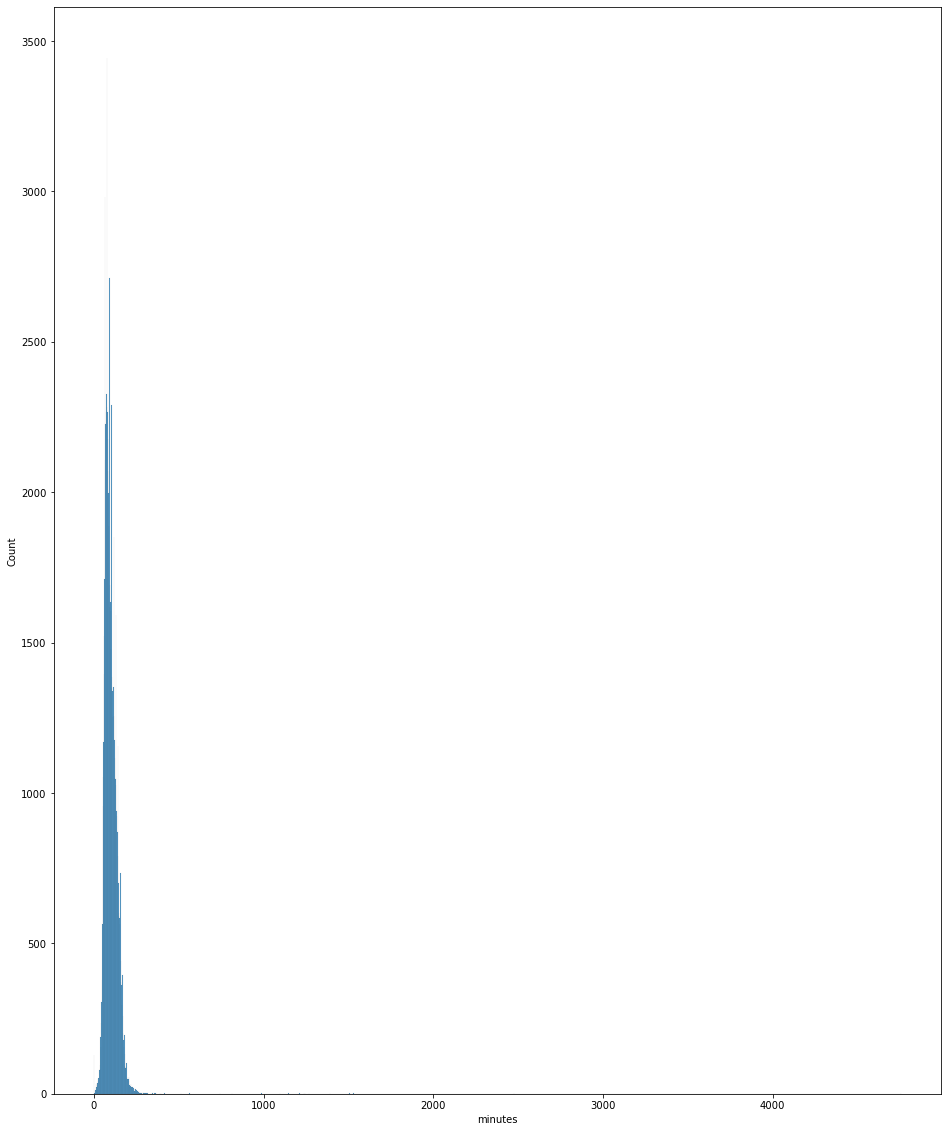

In [84]:
#create a plot that represent the distribution of values on 'minutes' attribute.
plt.figure(figsize=(35,20))
plt.subplot(1,2,1)
sns.histplot(df_ten_match['minutes'])
plt.show()

/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='minutes'>

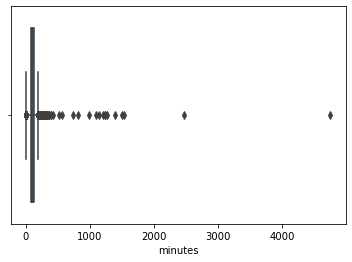

In [85]:
sns.boxplot(df_ten_match['minutes']) #draw a box plot to show distributions with respect to categories

For detecting the outliers we use __Interquartile Range__ (IQR) proximity rule. 
First of all, we got the 25th and 75th percentile of the __'minutes'__ values on the dataset.

In [86]:
#get 25th and 75th quantile in 'minutes' attribute
perc25_minutes = df_ten_match['minutes'].quantile(0.25)
perc75_minutes = df_ten_match['minutes'].quantile(0.75)
print("Percentile 25° of minutes attributes", perc25_minutes)
print("Percentile 75° of minutes attributes", perc75_minutes)

Percentile 25° of minutes attributes 72.0
Percentile 75° of minutes attributes 119.0


In the rule, the data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.
Q1 and Q3 are the 25th and 75th percentile previously computed, instead, IQR represents the inter-quartile range and is given by Q3 – Q1.

In [87]:
#apply the rule and get upper/lower limit
iqr = perc75_minutes - perc25_minutes #get iqr 
#calculate the upper and lower limit 
upper_limit_minutes = perc75_minutes + 1.5 * iqr
lower_limit_minutes = perc25_minutes - 1.5 * iqr
print("Upper limit of minutes", upper_limit_minutes)
print("Lower limit of minutes", lower_limit_minutes)

Upper limit of minutes 189.5
Lower limit of minutes 1.5


In [88]:
#check the outliers above the upper limit
df_ten_match[df_ten_match['minutes'] > upper_limit_minutes]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
65437,2016-0221,Tampere CH,Clay,32.0,C,20160718.0,268.0,111193.0,NaN,Alexander Vasilenko,...,18.0,16.0,7.0,11.0,571.0,54.0,479.0,80.0,3355.0,642279.97
66520,2016-0410,Monte Carlo Masters,Clay,64.0,M,20160411.0,243.0,104655.0,NaN,Pablo Cuevas,...,39.0,18.0,9.0,11.0,25.0,1510.0,131.0,439.0,5638.0,1202356.35
66924,2016-0447,Samarkand CH,Clay,32.0,C,20160509.0,278.0,122078.0,NaN,Dmitry Popko,...,6.0,8.0,2.0,5.0,208.0,263.0,266.0,193.0,2038.0,334531.73
67408,2016-0533,Sao Paulo,Clay,32.0,A,20160222.0,268.0,105671.0,NaN,Gastao Elias,...,29.0,16.0,12.0,16.0,140.0,430.0,197.0,267.0,2441.0,427277.95
162584,2016-0605,Tour Finals,Hard,8.0,F,20161114.0,296.0,104918.0,NaN,Andy Murray,...,18.0,16.0,3.0,7.0,1.0,11185.0,5.0,4705.0,1056.0,212896.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94671,2021-9531,Salzburg CH,Clay,32.0,C,20210705.0,290.0,106000.0,NaN,Damir Dzumhur,...,21.0,16.0,10.0,15.0,128.0,626.0,113.0,700.0,3683.0,792468.79
94992,2021-9538,Pozoblanco CH,Hard,32.0,C,20210719.0,243.0,208540.0,WC,Inaki Montes De La Torre,...,23.0,16.0,13.0,18.0,1408.0,3.0,459.0,86.0,2244.0,405840.06
95380,2021-9540,San Marino CH,Clay,32.0,C,20210809.0,290.0,110778.0,NaN,Joao Menezes,...,29.0,18.0,6.0,8.0,233.0,295.0,352.0,130.0,3346.0,744084.50
95471,2021-9544,Verona CH,Clay,32.0,C,20210816.0,282.0,126125.0,NaN,Maxime Janvier,...,24.0,17.0,6.0,9.0,246.0,273.0,265.0,234.0,3835.0,731826.62


In [89]:
#check the outliers below the lower limit
df_ten_match[df_ten_match['minutes'] < lower_limit_minutes]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
52900,2016-0300,Luxembourg,Hard,32.0,I,20161017.0,294.0,201512.0,NaN,Monica Niculescu,...,0.0,0.0,0.0,0.0,51.0,1160.0,17.0,2220.0,3735.0,697448.71
53009,2016-0406,Strasbourg,Clay,32.0,I,20160516.0,296.0,201614.0,NaN,Caroline Garcia,...,0.0,0.0,0.0,0.0,55.0,1080.0,23.0,2270.0,3308.0,676430.07
53071,2016-0528,Linz,Hard,32.0,I,20161010.0,299.0,203530.0,NaN,Viktorija Golubic,...,0.0,0.0,0.0,0.0,62.0,967.0,7.0,3687.0,2236.0,377980.44
53377,2016-0804,Charleston,Clay,64.0,P,20160404.0,235.0,206183.0,NaN,Cindy Burger,...,0.0,0.0,0.0,0.0,159.0,358.0,107.0,645.0,5728.0,1266592.77
53499,2016-0806,Montreal,Hard,64.0,P,20160725.0,275.0,201662.0,NaN,Karolina Pliskova,...,0.0,0.0,0.0,0.0,17.0,2540.0,25.0,1880.0,7173.0,1385835.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93217,2021-9475,Oeiras 2 CH,Clay,32.0,C,20210405.0,295.0,105671.0,SE,Gastao Elias,...,NaN,NaN,NaN,NaN,323.0,156.0,243.0,265.0,2858.0,598369.24
93889,2021-9503,Biella 6 CH,Clay,32.0,C,20210517.0,245.0,109686.0,NaN,Riccardo Bonadio,...,NaN,NaN,NaN,NaN,293.0,191.0,458.0,84.0,3189.0,641719.64
63368,2021-9512,Belgrade 2,Clay,32.0,A,20210524.0,294.0,105643.0,NaN,Federico Delbonis,...,NaN,NaN,NaN,NaN,52.0,1170.0,98.0,794.0,3284.0,673010.44
94952,2021-9536,Nur-Sultan 4 CH,Hard,32.0,C,20210719.0,245.0,106169.0,NaN,Vladyslav Manafov,...,NaN,NaN,NaN,NaN,527.0,68.0,629.0,45.0,4431.0,618636.98


In [90]:
#create a dataframe with trimming the 'minutes' values 
trim_minutes = df_ten_match[df_ten_match['minutes'] < upper_limit_minutes]
trim_minutes.shape

(80339, 49)

Now, we have compared two datasets: one trimmed dataset and one not trimmed dataset. The trimming operation excludes the outlier values from our analysis. By applying this technique our data becomes thin when there are more outliers present in the dataset. 

/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


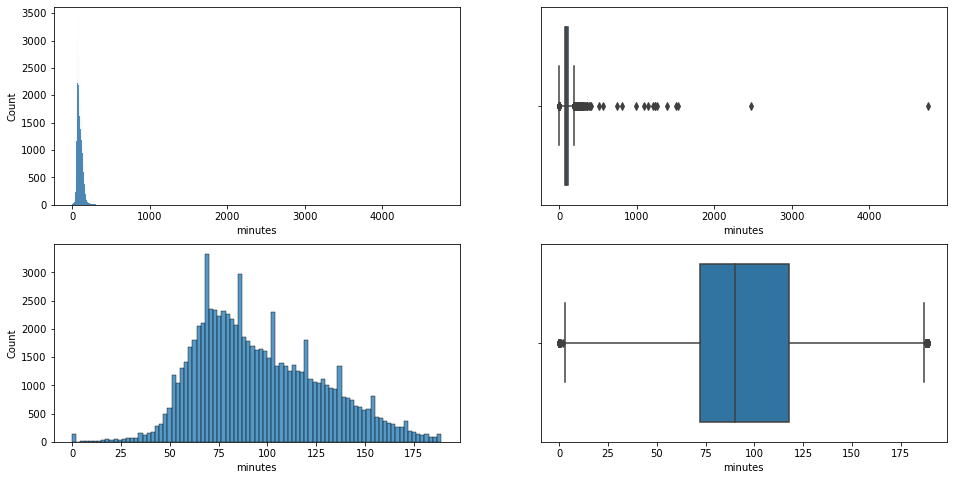

In [91]:
#compare the plots with the different dataframes: no trimmed, trimmed
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df_ten_match['minutes'])
plt.subplot(2,2,2)
sns.boxplot(df_ten_match['minutes'])
plt.subplot(2,2,3)
sns.histplot(trim_minutes['minutes'])
plt.subplot(2,2,4)
sns.boxplot(trim_minutes['minutes'])
plt.show()

These charts show the situation before and after the trimming applications.
The first chart shows the distribution of the __'minutes'__ attribute, we have expected the values approximately normally distributed, but the chart shows clearly that some values are wrong because it cannot be possible that exist a match longer than 4000 minutes.
The IQR proximity rule detects the upper and lower limit, indeed the second chart shows the values normally distributed as we expected. Although we have still some weird values on the lower limit, we think that it is unlikely that some matches finished so fast. 
The next chart shows after capping operation.

In [92]:
#create a dataframe with capping the 'minutes' values 
cap_minutes = df_ten_match.copy()
#get data between upper and lower limit
cap_minutes['minutes'] = np.where(
    cap_minutes['minutes'] > upper_limit_minutes,
    upper_limit_minutes,
    np.where(
        cap_minutes['minutes'] < lower_limit_minutes,
        lower_limit_minutes,
        cap_minutes['minutes']
    )
)

In this technique, we cap our outliers data and make the limit i.e, above a particular value or less than that value, all the values will be considered as outliers, and the number of outliers in the dataset gives that capping number.

/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


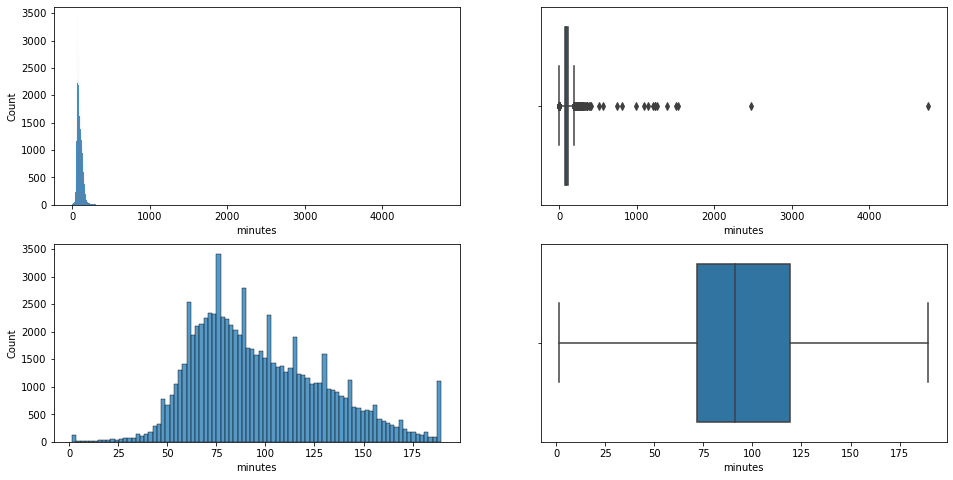

In [93]:
#compare the plots with the different dataframes: no capping, capping
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df_ten_match['minutes'])
plt.subplot(2,2,2)
sns.boxplot(df_ten_match['minutes'])
plt.subplot(2,2,3)
sns.histplot(cap_minutes['minutes'])
plt.subplot(2,2,4)
sns.boxplot(cap_minutes['minutes'])
plt.show()

After this analysis about the outliers in the attribute __"minutes"__, we have realized that there were more values which were not corrected; in fact, in 1946 the shortest tennis match lasted 18 minutes, for example.
In more recent matches (2019 - nowadays), the shortest lasted 58 minutes.
For what concerns the longest match, in 2018 there was a match that lasted 6:36, it proves that the upper limit is not correct.
For removing the outliers we applied this information got by the wiki.

In [94]:
# remove outliers in original dataframe
df_ten_match['minutes'] = np.where(
    df_ten_match['minutes'] > 396,
    396,
    np.where(
        df_ten_match['minutes'] < 45,
        45,
        df_ten_match['minutes']
    )
)

 ## Players' height ##
 
We have analyzed the players' height. On the dataset, this information is represented by the __'winner_ht'__ and __'loser_ht'__ attributes. By now, we have analyzed only __'winner_ht'__ values. Primarily, we have checked the information about the __'winner_ht'__ attribute and we have immediately noticed some wrong values, secondly, the charts have defined in a right way the problem with these values. 

In [95]:
df_ten_match['winner_ht'].describe() #pre removing outliers

count    51417.000000
mean       180.976720
std         12.080592
min          2.000000
25%        175.000000
50%        182.000000
75%        188.000000
max        211.000000
Name: winner_ht, dtype: float64

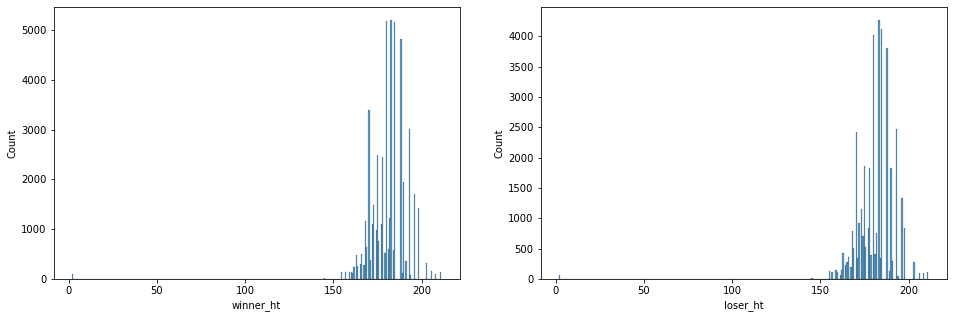

In [96]:
#plotting both winner and loser players' height
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df_ten_match['winner_ht'])
plt.subplot(1,2,2)
sns.histplot(df_ten_match['loser_ht'])
plt.show()

We use empirical relations of normal distribution.
The data points which fall below mean-3*(sigma) or above mean+3*(sigma) are outliers, where mean and sigma are the average value and standard deviation of a particular column, in this case, __'winner_ht'__.

In [97]:
#apply the rule to get highest and lowest limit
highest_wht = df_ten_match['winner_ht'].mean() + 3*df_ten_match['winner_ht'].std()
lowest_wht = df_ten_match['winner_ht'].mean() - 3*df_ten_match['winner_ht'].std()
print("Highest allowed", highest_wht)
print("Lowest allowed", lowest_wht)

Highest allowed 217.2184956278799
Lowest allowed 144.734943896013


In [98]:
#Finding outliers
df_ten_match[(df_ten_match['winner_ht'] > highest_wht) | (df_ten_match['winner_ht'] < lowest_wht)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
127228,2018-W-WITF-KAZ-04A-2018,Shymkent $15K,Clay,32.0,15,20180917.0,9.0,215872.0,NaN,Kamilla Rakhimova,...,NaN,NaN,NaN,NaN,928.0,12.0,829.0,18.0,3622.0,716876.75
127256,2018-W-WITF-KAZ-05A-2018,Shymkent $15K,Clay,32.0,15,20180924.0,6.0,215872.0,NaN,Kamilla Rakhimova,...,NaN,NaN,NaN,NaN,920.0,12.0,NaN,NaN,3597.0,964777.59
129187,2018-W-WITF-RUS-01A-2018,Moscow $15K,Hard,32.0,15,20180226.0,18.0,215872.0,NaN,Kamilla Rakhimova,...,NaN,NaN,NaN,NaN,NaN,NaN,1019.0,8.0,3586.0,563189.16
129173,2018-W-WITF-RUS-01A-2018,Moscow $15K,Hard,32.0,15,20180226.0,4.0,215872.0,NaN,Kamilla Rakhimova,...,NaN,NaN,NaN,NaN,NaN,NaN,487.0,67.0,3586.0,563189.16
129214,2018-W-WITF-RUS-02A-2018,Kazan $15K,Hard,32.0,15,20180312.0,14.0,215872.0,WC,Kamilla Rakhimova,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2768.0,498429.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100200,2021-806,Montreal,Hard,64.0,P,20210809.0,216.0,215872.0,NaN,Kamilla Rakhimova,...,5.0,7.0,3.0,9.0,137.0,628.0,1013.0,16.0,8077.0,1094101.37
163504,2021-W-ITF-CRO-01A-2021,W60 Zagreb,Clay,32.0,60,20210426.0,401.0,215872.0,NaN,Kamilla Rakhimova,...,NaN,NaN,NaN,NaN,139.0,582.0,1092.0,11.0,2343.0,546016.19
163494,2021-W-ITF-CRO-01A-2021,W60 Zagreb,Clay,32.0,60,20210426.0,203.0,215872.0,NaN,Kamilla Rakhimova,...,NaN,NaN,NaN,NaN,139.0,582.0,238.0,290.0,2343.0,546016.19
163480,2021-W-ITF-CRO-01A-2021,W60 Zagreb,Clay,32.0,60,20210426.0,105.0,215872.0,NaN,Kamilla Rakhimova,...,NaN,NaN,NaN,NaN,139.0,582.0,179.0,408.0,2343.0,546016.19


In [99]:
#create a dataframe without outliers
trim_wht = df_ten_match[(df_ten_match['winner_ht'] < highest_wht) & (df_ten_match['winner_ht'] > lowest_wht)]
trim_wht

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
185773,0-CTai,Taipei,Hard,32.0,C,NaN,285.0,NaN,NaN,NaN,...,18.0,14.0,NaN,5.0,79.0,NaN,NaN,NaN,NaN,638954.72
185794,10-CTai,Taipei,Hard,32.0,C,NaN,253.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3535.0,638954.72
185797,12-CTai,Taipei,Hard,32.0,C,NaN,NaN,NaN,NaN,NaN,...,15.0,12.0,NaN,NaN,NaN,217.0,208.0,274.0,NaN,NaN
185777,2-Tai,Taipei,Hard,32.0,15,NaN,289.0,201648.0,NaN,Naomi Broady,...,NaN,14.0,NaN,NaN,NaN,501.0,NaN,NaN,3535.0,638954.72
65300,2016-0083,Eckental CH,Hard,32.0,C,20161031.0,296.0,200282.0,Q,Alex De Minaur,...,17.0,16.0,5.0,11.0,546.0,61.0,329.0,143.0,3121.0,630526.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176726,2021-W-ITF-USA-16A-2021,W100 Landisville PA (MOVED FROM 02 AUG),Hard,32.0,100,20210809.0,112.0,201621.0,Q,Mona Barthel,...,NaN,NaN,NaN,NaN,213.0,338.0,521.0,82.0,2479.0,434531.50
176729,2021-W-ITF-USA-16A-2021,W100 Landisville PA (MOVED FROM 02 AUG),Hard,32.0,100,20210809.0,115.0,211107.0,NaN,Katie Boulter,...,NaN,NaN,NaN,NaN,191.0,391.0,509.0,85.0,2479.0,434531.50
185779,4-Tai,Taipei,Hard,32.0,15,NaN,291.0,202505.0,WC,Belinda Bencic,...,13.0,NaN,NaN,10.0,120.0,502.0,231.0,NaN,NaN,NaN
185782,6-Tai,Taipei,Hard,32.0,15,NaN,295.0,201648.0,NaN,Naomi Broady,...,3.0,NaN,0.0,4.0,122.0,NaN,NaN,217.0,NaN,NaN


Finally, we create a new dataframe without any outlier.

In [100]:
#create a copy of dataframe without outliers in the 'winner_ht' attribute 
zscore_wht = df_ten_match.copy()
zscore_wht['winner_ht'] = np.where(
    zscore_wht['winner_ht'] > highest_wht,
    highest_wht,
    np.where(
        zscore_wht['winner_ht'] < lowest_wht,
        lowest_wht,
        zscore_wht['winner_ht']
    )
)

On the new dataframe, we have noticed a better distribution without wrong values, but according to us, this technique could have removed also some correct values.
After this operation, we easily noticed that only one wrong value remained.

In [101]:
zscore_wht['winner_ht'].describe() #check the new values that assumed the attribute after to remove outliers on 'winner_ht'

count    51417.000000
mean       181.254322
std          9.279938
min        144.734944
25%        175.000000
50%        182.000000
75%        188.000000
max        211.000000
Name: winner_ht, dtype: float64

## Age of winner players ##
We have studied the __'winner_age'__ distribution to detect the outliers, using the IQR rule.

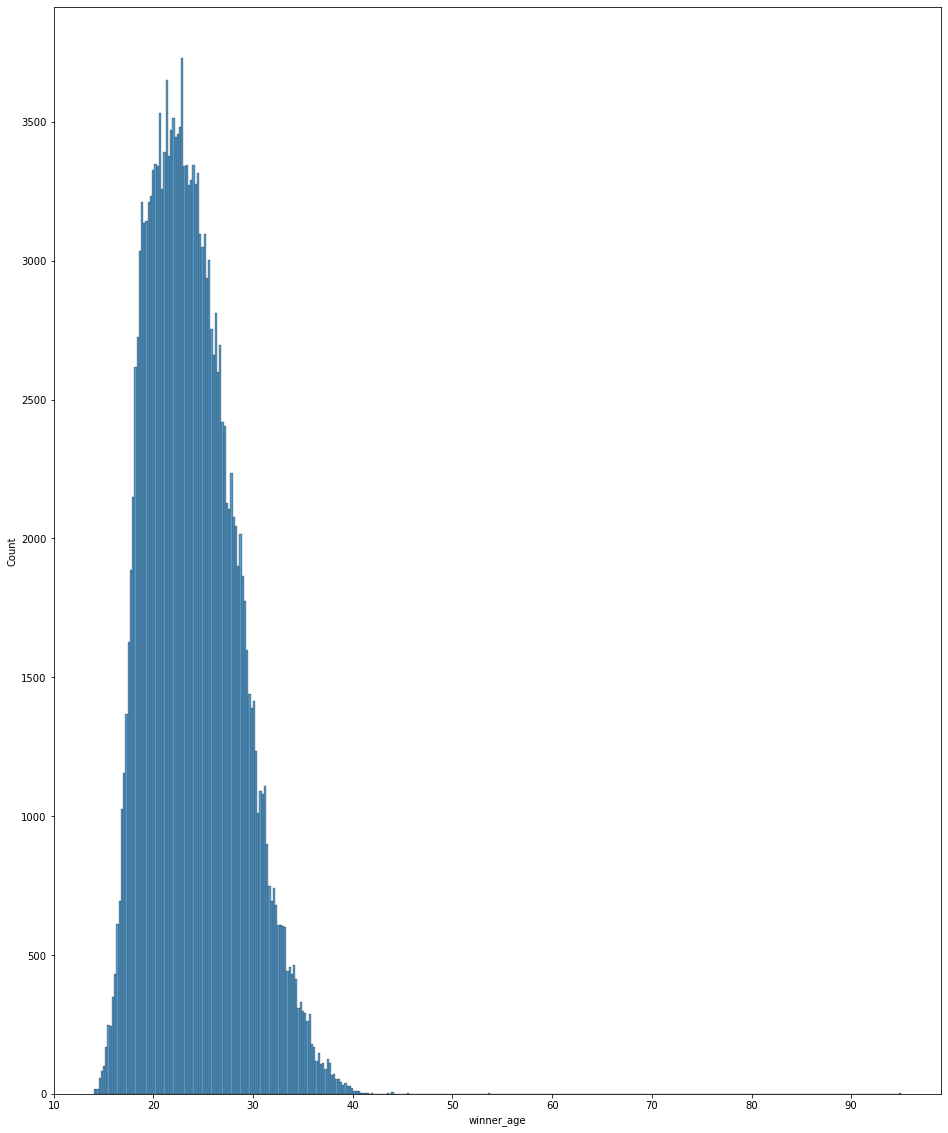

In [102]:
#plotting the "winner_age" attribute
plt.figure(figsize=(35,20))
plt.subplot(1,2,1)
sns.histplot(df_ten_match['winner_age'])
plt.show()

/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='winner_age'>

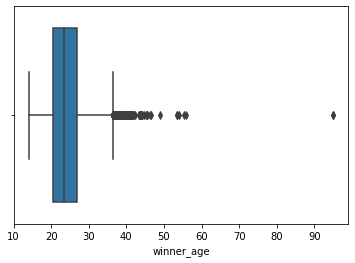

In [103]:
sns.boxplot(df_ten_match['winner_age'])

In [104]:
#get quantile for the "winner_age" attribute
perc25_winner_age = df_ten_match['winner_age'].quantile(0.25)
perc75_winner_age = df_ten_match['winner_age'].quantile(0.75)
print("Percentile 25° of winner_age attributes", perc25_winner_age)
print("Percentile 75° of winner_age attributes", perc75_winner_age)
iqr = perc75_winner_age - perc25_winner_age
#apply the rule and get upper/lower limit
upper_limit_age = perc75_winner_age + 1.5 * iqr
lower_limit_age = perc25_winner_age - 1.5 * iqr
print("Upper limit of winner_age", upper_limit_age)
print("Lower limit of winner_age", lower_limit_age)

Percentile 25° of winner_age attributes 20.4900752909
Percentile 75° of winner_age attributes 26.8692676249
Upper limit of winner_age 36.438056125900005
Lower limit of winner_age 10.921286789899995


In [105]:
df_ten_match[df_ten_match['winner_age'] > upper_limit_age] #check the outliers above the upper limit

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
65309,2016-0091,Kyoto CH,Hard,32.0,C,20160222.0,246.0,103175.0,NaN,Toshihide Matsui,...,20.0,10.0,7.0,9.0,773.0,28.0,1781.0,1.0,1928.0,366147.96
65369,2016-0213,San Luis Potosi CH,Clay,32.0,C,20160321.0,247.0,101339.0,WC,Agustin Moreno,...,11.0,9.0,2.0,6.0,NaN,NaN,461.0,87.0,3372.0,581493.12
65465,2016-0221,Tampere CH,Clay,32.0,C,20160718.0,296.0,103105.0,NaN,Ruben Ramirez Hidalgo,...,6.0,7.0,5.0,10.0,231.0,234.0,291.0,167.0,3355.0,642279.97
65448,2016-0221,Tampere CH,Clay,32.0,C,20160718.0,279.0,103105.0,NaN,Ruben Ramirez Hidalgo,...,19.0,12.0,1.0,4.0,231.0,234.0,250.0,212.0,3355.0,642279.97
65459,2016-0221,Tampere CH,Clay,32.0,C,20160718.0,290.0,103105.0,NaN,Ruben Ramirez Hidalgo,...,8.0,12.0,8.0,12.0,231.0,234.0,227.0,237.0,3355.0,642279.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170925,2021-W-ITF-RUS-01A-2021,W25 Moscow,Hard,32.0,25,20210222.0,103.0,201454.0,NaN,Akgul Amanmuradova,...,NaN,NaN,NaN,NaN,425.0,110.0,903.0,21.0,4906.0,952322.74
171244,2021-W-ITF-SRB-01A-2021,W15 Prokuplje,Clay,32.0,15,20210628.0,207.0,203095.0,NaN,Ioana Gaspar,...,NaN,NaN,NaN,NaN,673.0,48.0,798.0,31.0,3696.0,839031.01
171234,2021-W-ITF-SRB-01A-2021,W15 Prokuplje,Clay,32.0,15,20210628.0,113.0,203095.0,NaN,Ioana Gaspar,...,NaN,NaN,NaN,NaN,673.0,48.0,748.0,37.0,3696.0,839031.01
176523,2021-W-ITF-USA-12A-2021,W25 Pelham AL,Clay,48.0,25,20210517.0,203.0,202273.0,NaN,Liga Dekmeijere,...,NaN,NaN,NaN,NaN,NaN,NaN,529.0,77.0,4604.0,1024263.68


In [106]:
#applying the trimming
trim_age = df_ten_match[df_ten_match['winner_age'] < upper_limit_age]
trim_age.shape

(181742, 49)

/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


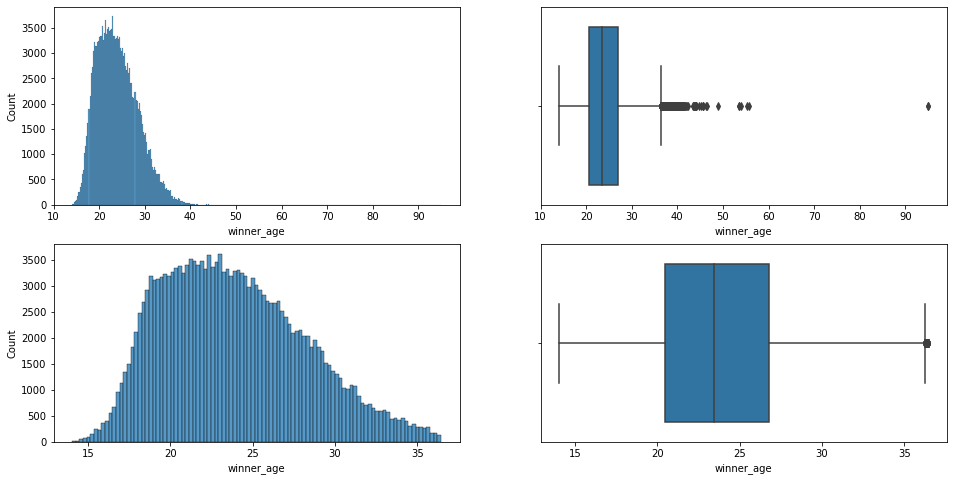

In [107]:
#compare the graph to test the operation
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df_ten_match['winner_age'])
plt.subplot(2,2,2)
sns.boxplot(df_ten_match['winner_age'])
plt.subplot(2,2,3)
sns.histplot(trim_age['winner_age'])
plt.subplot(2,2,4)
sns.boxplot(trim_age['winner_age'])
plt.show()

In [108]:
#create a copy of the dataset without the outliers
cap_age = df_ten_match.copy()
cap_age['winner_age'] = np.where(
    cap_age['winner_age'] > upper_limit_age,
    upper_limit_age,
    np.where(
        cap_age['winner_age'] < lower_limit_age,
        lower_limit_age,
        cap_age['winner_age']
    )
)

/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/feeded/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


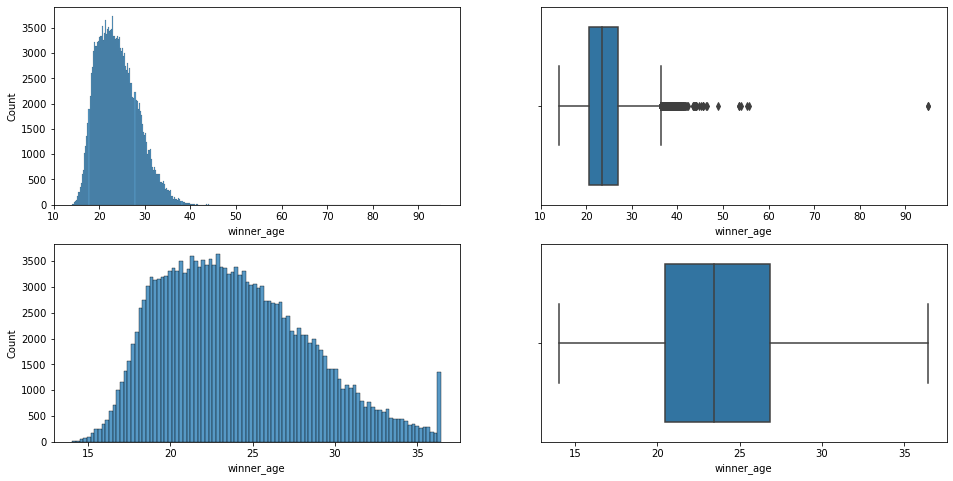

In [109]:
#compare all plot
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df_ten_match['winner_age'])
plt.subplot(2,2,2)
sns.boxplot(df_ten_match['winner_age'])
plt.subplot(2,2,3)
sns.histplot(cap_age['winner_age'])
plt.subplot(2,2,4)
sns.boxplot(cap_age['winner_age'])
plt.show()

## Searching wrong value on winner_ht and loser_ht ##

We noticed there is a wrong value on __"winner_ht"__ and __"loser_ht"__ attribute, e.g. there is a __'2.0'__ (centimetres). But since it is not possible that exists a player with 2cm high.
We searching all players with __"winner_ht"__ == __'2.0'__ and we have achieved one result where a player has the wrong value.

In [110]:
df_ten_match.winner_ht.unique() #searching unusual value on winner_ht attribute 

array([182.,  nan, 170., 175., 189., 183., 193., 180., 190., 178., 188.,
       198., 173., 191., 211., 185., 196., 168., 174., 177., 157., 179.,
       166., 181., 203., 206., 163., 208., 172., 155., 169., 171., 176.,
       184., 194., 161., 159., 165., 162., 164., 167., 145., 160.,   2.])

In [111]:
wrong_winner_ht = df_ten_match[['winner_name', 'winner_ht']].loc[(df_ten_match.winner_ht == 2.0)] #searching all winner_name with wrong height (2cm)
wrong_winner_ht = wrong_winner_ht.drop_duplicates(subset=['winner_name'], keep='first', inplace=False) #drop all duplicate records
wrong_winner_ht #we have one only result

,winner_name,winner_ht
127228,Kamilla Rakhimova,2.0


Given that the player with the wrong value is only 'Kamilla Rakhimova' then we update the records with her right height, according to her page on wikipedia.

In [112]:
#change all records with "winner_ht" == 2 and if the winner name is same to "winner_name" in wrong_winner_ht dataset then update with right height.
df_ten_match.loc[(df_ten_match.winner_ht == 2.0) & (df_ten_match.winner_name == wrong_winner_ht.winner_name.iloc[0]), 'winner_ht'] = 174.0

In [113]:
df_ten_match.winner_ht.unique() #check if the wrong value is removed

array([182.,  nan, 170., 175., 189., 183., 193., 180., 190., 178., 188.,
       198., 173., 191., 211., 185., 196., 168., 174., 177., 157., 179.,
       166., 181., 203., 206., 163., 208., 172., 155., 169., 171., 176.,
       184., 194., 161., 159., 165., 162., 164., 167., 145., 160.])

Same procedure with __"loser_ht"__ attribute:

In [114]:
df_ten_match.loser_ht.unique() #searching unusual value on loser_ht attribute 

array([159.,  nan, 183., 190., 185., 180., 188., 193., 203., 198., 175.,
       173., 178., 191., 211., 196., 166., 181., 169., 165., 177., 176.,
       182., 170., 174., 157., 168., 160., 179., 208., 206., 163., 172.,
       155., 167., 171., 164., 184., 194., 162., 189., 161., 145.,   2.])

In [115]:
wrong_loser_ht = df_ten_match[['loser_name', 'loser_ht']].loc[(df_ten_match.loser_ht == 2.0)] #searching all loser_name with wrong height (2cm)
wrong_loser_ht = wrong_loser_ht.drop_duplicates(subset=['loser_name'], keep='first', inplace=False) #drop all duplicate records
wrong_loser_ht #we have one only result

,loser_name,loser_ht
41965,Kamilla Rakhimova,2.0


We did here the same thing:

In [116]:
#change all records with "loser_ht" == 2 and if the loser name is same to "loser_name" in wrong_loser_ht dataset then update with right height.
df_ten_match.loc[(df_ten_match.loser_ht == 2.0) & (df_ten_match.loser_name == wrong_loser_ht.loser_name.iloc[0]), 'loser_ht'] = 174.0

In [117]:
df_ten_match.loser_ht.unique() #check if the wrong value is removed

array([159.,  nan, 183., 190., 185., 180., 188., 193., 203., 198., 175.,
       173., 178., 191., 211., 196., 166., 181., 169., 165., 177., 176.,
       182., 170., 174., 157., 168., 160., 179., 208., 206., 163., 172.,
       155., 167., 171., 164., 184., 194., 162., 189., 161., 145.])

## Searching wrong values on winner_age ##

We noticed there is a wrong value on __"winner_age"__ attribute, indeed there are two players who are 95 years old. Since that it was very odd we searched some information about them and we saw that the age on the dataset did not correspond to their real age.

In [118]:
wrong_ages = df_ten_match.loc[df_ten_match['winner_age'] >= 70] #showing wrong values on winner_age
wrong_ages

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
322,2019-580,Australian Open,Hard,128.0,G,20190114.0,197.0,106421.0,LL,Daniil Medvedev,...,15.0,14.0,5.0,11.0,19.0,1865.0,22.0,1785.0,15583.0,2781000.18
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69


Given that the players with the wrong value are only __'Daniil Medvedev'__ and __'Kei Nishikori'__ then we updated the records with their right age when they played that match, using the median with all ages that correspond to __'tourney_date'__.

In [119]:
#get median about Daniil Medvedev's age when he played that match 
median_Medvedev = np.median(df_ten_match.loc[(df_ten_match['winner_name'] == 'Daniil Medvedev') & (df_ten_match['winner_age'] != 95) & (df_ten_match['tourney_date'] == 20190114.0)]['winner_age'])
#update the record
df_ten_match.loc[(df_ten_match['winner_name'] == 'Daniil Medvedev') & (df_ten_match['tourney_date'] == 20190114.0), 'winner_age'] = median_Medvedev

#get median about Daniil Medvedev's age when he played that match 
median_Nishikori = np.median(df_ten_match.loc[(df_ten_match['winner_name'] == 'Kei Nishikori') & (df_ten_match['winner_age'] != 95) & (df_ten_match['tourney_date'] == 20181231.0)]['winner_age'])
#update the record
df_ten_match.loc[(df_ten_match['winner_name'] == 'Kei Nishikori') & (df_ten_match['tourney_date'] == 20181231.0), 'winner_age'] = median_Nishikori

# Working on the female and male datasets

## Female

In [120]:
dff = pd.read_csv('./female_players.csv', sep = ',')

In [121]:
dff.isnull().sum()

name       1667
surname       0
dtype: int64

We'll surely have to deal with the name nans.
A more thorough analysis showed names and surnames with only one letter. We decided to remove those.

In [122]:
names_indexes = dff['name'].unique()
surnames_indexes = dff['surname'].unique()
print(len(dff.index), 'total female players')
print(len(names_indexes), 'unique names')
print(len(surnames_indexes), 'unique surnames')

46172 total female players
10309 unique names
28756 unique surnames


In [123]:
dff.dropna(subset=['name'], inplace = True)
dff = dff[dff['name'].map(len,na_action='ignore')>1].copy()
dff = dff[dff['surname'].map(len)>1].copy()

We added the full-name attribute (the merge will hinge on it) and we discarded the columns used to create it.

In [124]:
full_name = []
for i in range(dff.shape[0]):
    full_name.append(str(dff['name'].iloc[i]) + ' ' + str(dff['surname'].iloc[i]))
dff['full_name'] = full_name
dff.drop(['name', 'surname'], axis=1, inplace=True)

Now we only need to add a new column, the gender, that will be merged later with the main dataframe.

In [125]:
dff['gender']='F'

## Male

In [126]:
dfm = pd.read_csv('./male_players.csv', sep = ',')

In [127]:
dfm.isnull().sum()

name       177
surname     42
dtype: int64

Here we have nans both on the name and on the surname attributes...

In [128]:
names_indexes = dfm['name'].unique()
surnames_indexes = dfm['surname'].unique()
print(len(dfm.index), 'total male players')
print(len(names_indexes), 'unique names')
print(len(surnames_indexes), 'unique surnames')

55208 total male players
13457 unique names
35387 unique surnames


In [129]:
dfm.dropna(subset=['name'], inplace = True)
dfm.isnull().sum()

name       0
surname    0
dtype: int64

... but as we can see, their nan values on the surname attribute were all related to names.
Nonetheless, we still checked for names and surnames made of a single character:

In [130]:
dfm = dfm[dfm['name'].map(len,na_action='ignore')>1].copy()
dfm = dfm[dfm['surname'].map(len)>1].copy()

We added the full-name attribute (the merge will hinge on it) and we discard the columns used to create it.

In [131]:
full_name = []
for i in range(dfm.shape[0]):
    full_name.append(str(dfm['name'].iloc[i]) + ' ' + str(dfm['surname'].iloc[i]))
dfm['full_name'] = full_name
dfm.drop(['name', 'surname'], axis=1, inplace=True)

In [132]:
dfm['gender']='M'

And then we added the gender attribute. We are ready to merge everything together.

# Merge the datasets

To merge our dataframes, we concatenated the two dataframes about players' names, and we merged the result of this operation with the dataframe __"df_ten_match"__ on the attribute __"winner_name"__ and __"loser_name"__.

In [133]:
frames = [dff, dfm]
df_g = pd.concat(frames)
df_g = df_g.rename(columns={'full_name': 'winner_name', 'gender': 'winner_gender'})

df_j_gender = pd.merge(df_ten_match, df_g, left_on="winner_name", right_on="winner_name", how="left")
df_g = df_g.rename(columns={'winner_name': 'loser_name', 'winner_gender': 'loser_gender'})

df_j_gender = pd.merge(df_j_gender, df_g, left_on="loser_name", right_on="loser_name", how="left")
df_g = df_g.rename(columns={'loser_name': 'full_name', 'loser_gender': 'gender'})

Number of players by gender. Every player counted once (There are some players that don't appear in __"df_ten_match"__).

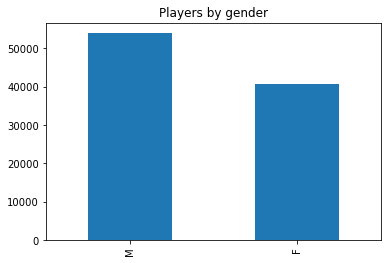

In [134]:
df_g['gender'].value_counts().plot(kind='bar',
                                   title='Players by gender')
plt.show()

### just to recap, these are the dataframes created in the next part and in the previous one: ###

__"df_g"__: contains information about the name, the surname and the gender of some players.

__"df_j_gender"__: similar to __"df_ten_match"__, but with a column for the gender of the player.

__"df_player_data_nd"__: contains information about every player who partecipated to a tournment, without any repetition (if a player played two times in the same tournment, in __"df_player_data_nd"__ is reported only one record about that player in that tournment).

__"df_player_data"__: contains information about every player who played a match, hence for every match played there are two records on this dataframe: one about the winner and the other about the loser..

__"df_tourney"__: contains information about every tournment played, there is a record for every tournment.



# Data Correlation #
In this part of the project, we have studied the correlation of some numerical attributes in our dataframe.

First of all, we have applied the correlation between spectators and revenue based on the tourney size, here we assumed that a bigger (__draw_size__) implies a bigger tourney's size. Using __Kendall correlation__.
We have created a scatter matrix about these attributes:

In [135]:
#create dataframe for studying correlation between draw_size and spectators and revenue.
corr_tourney = df_ten_match[['draw_size', 'tourney_spectators', 'tourney_revenue']]
corr_tourney

,draw_size,tourney_spectators,tourney_revenue
185773,32.0,NaN,638954.72
185774,32.0,NaN,638954.72
185794,32.0,3535.0,638954.72
185795,32.0,NaN,NaN
185797,32.0,NaN,NaN
...,...,...,...
185781,32.0,NaN,638954.72
185782,32.0,NaN,NaN
185788,32.0,3535.0,638954.72
185790,32.0,NaN,NaN


In [136]:
corr_tourney.corr(method = "kendall") #kendall correlation 

,draw_size,tourney_spectators,tourney_revenue
draw_size,1.000000,0.544605,0.521142
tourney_spectators,0.544605,1.000000,0.712823
tourney_revenue,0.521142,0.712823,1.000000


We have created a scatter matrix about these attributes.

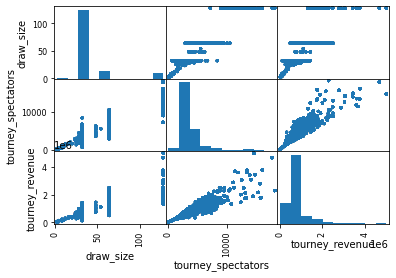

In [137]:
#create a matrix scatter plot
pd.plotting.scatter_matrix(df_ten_match[['draw_size', 'tourney_spectators', 'tourney_revenue']])
plt.show()

Then, we have studied the correlation among match stats (both winners and losers).

In [138]:
#create dataframe for studying the correlation between winner match stats and loser ones.
corr_all = df_ten_match[['winner_ht', 'winner_age', 'w_ace', 'w_df', 'w_1stWon', 'w_2ndWon', 'loser_ht', 'loser_age', 'l_ace', 'l_df', 'l_1stWon', 'l_2ndWon']]
corr_all

,winner_ht,winner_age,w_ace,w_df,w_1stWon,w_2ndWon,loser_ht,loser_age,l_ace,l_df,l_1stWon,l_2ndWon
185773,182.0,NaN,NaN,6.0,36.0,15.0,159.0,26.543463,2.0,NaN,37.0,18.0
185774,NaN,NaN,2.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
185794,170.0,NaN,NaN,NaN,NaN,NaN,NaN,21.289528,NaN,0.0,NaN,NaN
185795,NaN,19.512663,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,9.0
185797,175.0,NaN,NaN,NaN,36.0,NaN,NaN,27.791923,NaN,8.0,23.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
185781,NaN,26.918549,3.0,0.0,24.0,NaN,NaN,19.901437,NaN,6.0,NaN,4.0
185782,189.0,27.707050,12.0,1.0,NaN,NaN,175.0,NaN,6.0,2.0,18.0,3.0
185788,NaN,23.192334,NaN,4.0,30.0,13.0,NaN,NaN,4.0,7.0,27.0,10.0
185790,NaN,NaN,NaN,4.0,23.0,NaN,NaN,20.731006,7.0,NaN,NaN,8.0


In [139]:
corr_all.corr() #pearson correlation

,winner_ht,winner_age,w_ace,w_df,w_1stWon,w_2ndWon,loser_ht,loser_age,l_ace,l_df,l_1stWon,l_2ndWon
winner_ht,1.000000,0.120466,0.487005,-0.008524,0.187736,0.147552,0.459832,0.146715,0.219569,-0.064592,0.191535,0.175812
winner_age,0.120466,1.000000,0.076295,-0.052919,0.063102,0.033105,0.140410,0.235971,0.085123,-0.027260,0.059519,0.046738
w_ace,0.487005,0.076295,1.000000,0.137504,0.418014,0.297963,0.216371,0.103326,0.356705,0.025468,0.398457,0.330660
w_df,-0.008524,-0.052919,0.137504,1.000000,0.330838,0.351923,-0.073997,-0.014691,0.109725,0.252450,0.313435,0.312429
w_1stWon,0.187736,0.063102,0.418014,0.330838,1.000000,0.499471,0.192813,0.072401,0.486518,0.193297,0.831449,0.698190
w_2ndWon,0.147552,0.033105,0.297963,0.351923,0.499471,1.000000,0.172777,0.049921,0.391541,0.205381,0.649516,0.613240
loser_ht,0.459832,0.140410,0.216371,-0.073997,0.192813,0.172777,1.000000,0.121637,0.452536,0.017167,0.212215,0.171773
loser_age,0.146715,0.235971,0.103326,-0.014691,0.072401,0.049921,0.121637,1.000000,0.078171,-0.058455,0.080263,0.044990
l_ace,0.219569,0.085123,0.356705,0.109725,0.486518,0.391541,0.452536,0.078171,1.000000,0.150996,0.537151,0.417482
l_df,-0.064592,-0.027260,0.025468,0.252450,0.193297,0.205381,0.017167,-0.058455,0.150996,1.000000,0.206627,0.271539


In this scatter matrix, there are some attributes about the number of first and second service points (both winners and losers).

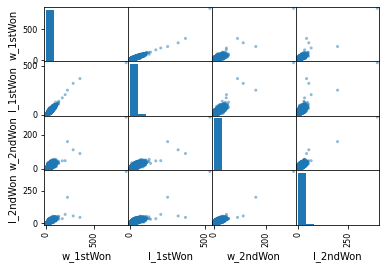

In [140]:
#create a matrix scatter plot
pd.plotting.scatter_matrix(df_ten_match[['w_1stWon', 'l_1stWon', 'w_2ndWon', 'l_2ndWon']])
plt.show()

In this scatter plot, we have considered the number of first service points between winners and losers, splitting them among right-handed and left-handed players.

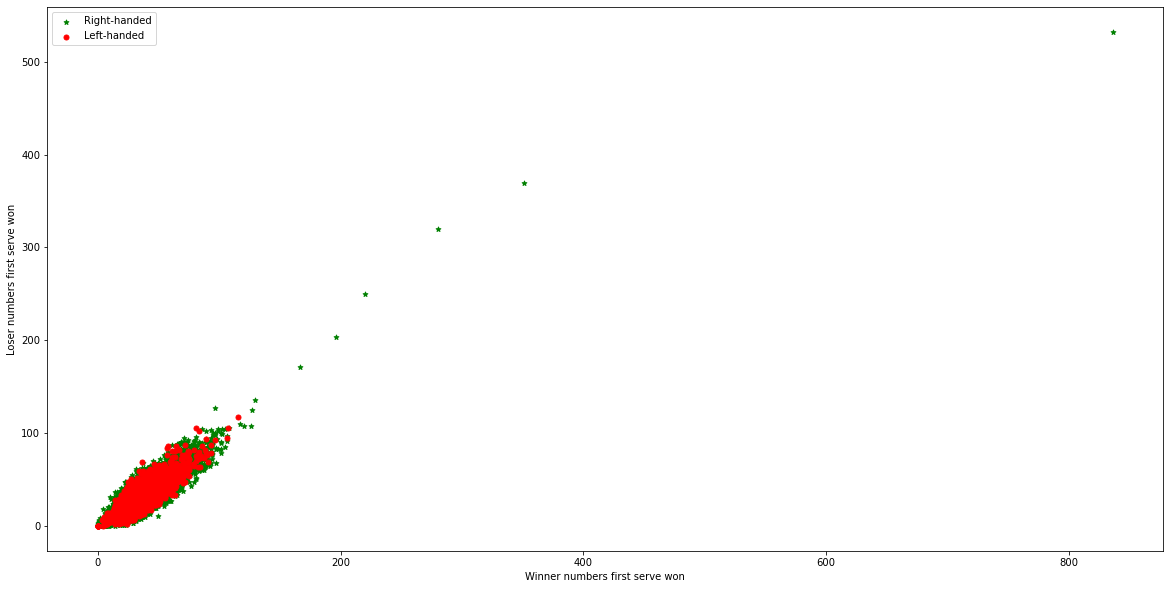

In [141]:
#compare number of first serve won between winners and losers specify to their serving hand 
plt.figure(figsize=(20,10))
plt.scatter(df_ten_match[df_ten_match['winner_hand'] == 'R']['w_1stWon'], 
            df_ten_match[df_ten_match['winner_hand'] == 'R']['l_1stWon'], color='g', marker='*', s= 25, label='Right-handed')

plt.scatter(df_ten_match[df_ten_match['winner_hand'] == 'L']['w_1stWon'], 
            df_ten_match[df_ten_match['winner_hand'] == 'L']['l_1stWon'], color='r', s = 25, label='Left-handed')
plt.xlabel('Winner numbers first serve won')
plt.ylabel('Loser numbers first serve won')
plt.legend()
plt.show()

Same reasoning but with the number of service points:

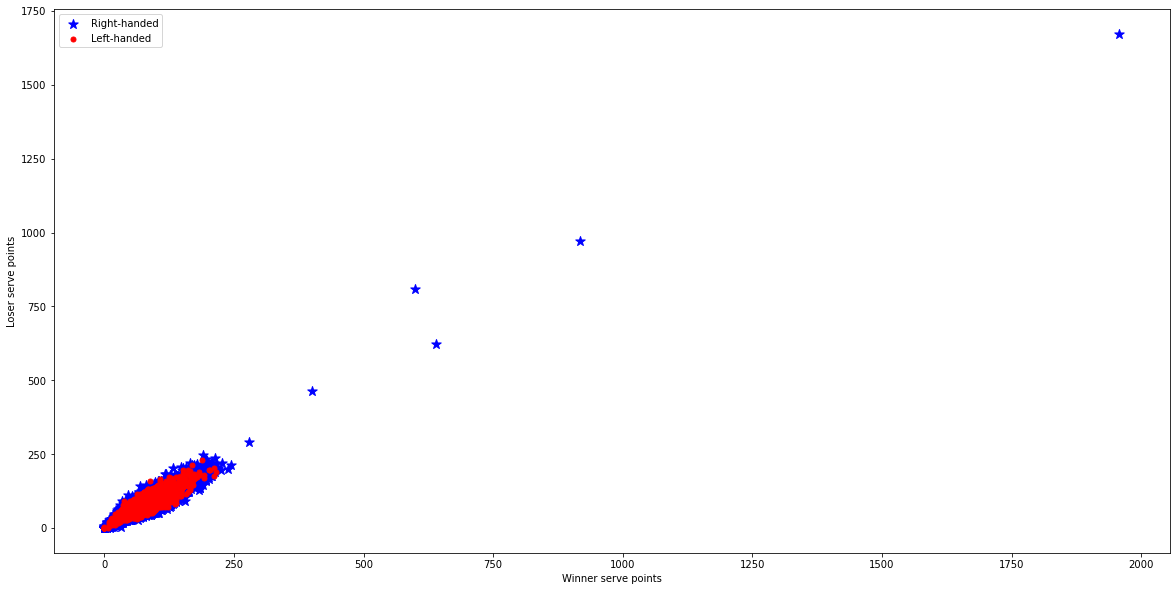

In [142]:
#compare serve points between winners and losers specify to their serving hand 
plt.figure(figsize=(20,10))
plt.scatter(df_ten_match[df_ten_match['winner_hand'] == 'R']['w_svpt'], 
            df_ten_match[df_ten_match['winner_hand'] == 'R']['l_svpt'], color='b', marker='*', s = 100, label='Right-handed')

plt.scatter(df_ten_match[df_ten_match['winner_hand'] == 'L']['w_svpt'], 
            df_ten_match[df_ten_match['winner_hand'] == 'L']['l_svpt'], color='r', s = 25, label='Left-handed')
plt.xlabel('Winner serve points')
plt.ylabel('Loser serve points')
plt.legend()
plt.show()

A scatter matrix about __winner_age__ and some winner player stats:

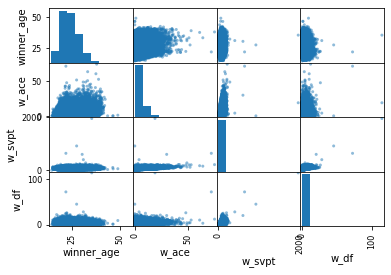

In [143]:
pd.plotting.scatter_matrix(df_ten_match[['winner_age', 'w_ace', 'w_svpt', 'w_df']])
plt.show()

We have created a scatter plot about the comparison between aces and faults, splitting them among winners and losers.

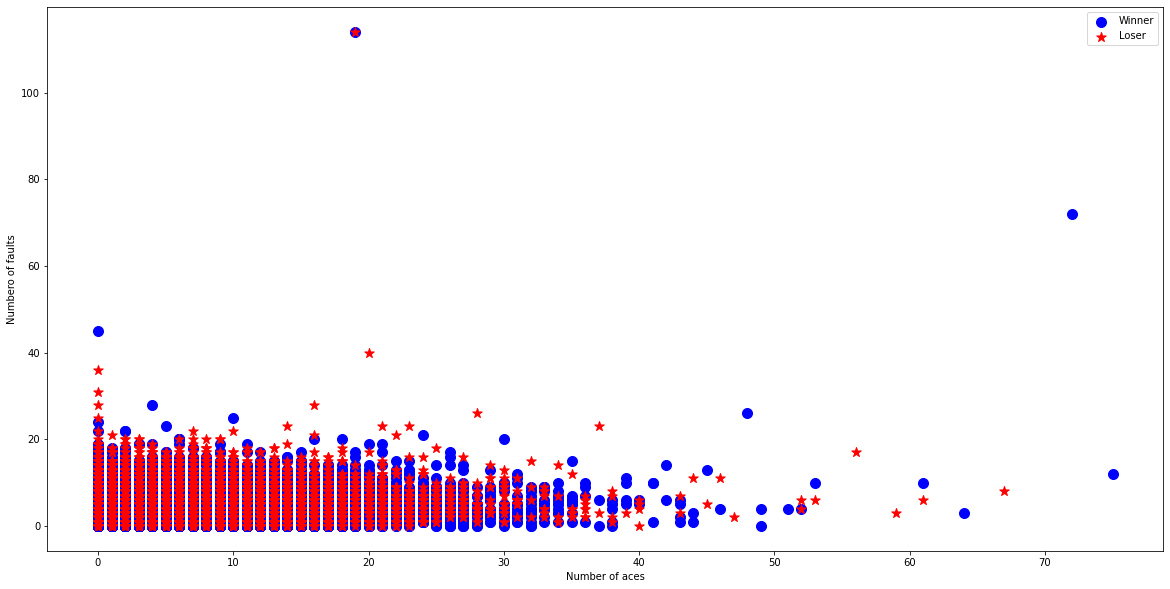

In [144]:
#compare aces and faults between winners and losers 
plt.figure(figsize=(20,10))
plt.scatter(df_ten_match['w_ace'], 
            df_ten_match['w_df'], color='b', s = 100, label='Winner')

plt.scatter(df_ten_match['l_ace'], 
            df_ten_match['l_df'], color='r', marker='*', s = 100, label='Loser')
plt.xlabel('Number of aces')
plt.ylabel('Numbero of faults')
plt.legend()
plt.show()

# Data Distribution #

In this part of the project, we are going to study how our data is distributed in our dataframe.

Firstly we created two new dataframes: the first one, which is called __df_player_data__, has two records for every record of __df_ten_match__; one record for the winners and one for the losers. This dataset was created to keep track of every match played. The second one is called __df_player_data_nd__, it contains just one records  for every partecipation in each tournament.

In [145]:
# creating a new dataframe containing all players' data
df_winner_data = df_j_gender[['tourney_id','tourney_date', 'tourney_level', 'winner_id', 'winner_name',
                              'winner_entry', 'winner_ht', 'winner_hand', 'winner_rank', 
                              'winner_rank_points','winner_gender', 'winner_age', 'w_ace', 'w_df',
                             'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
                             'w_bpSaved', 'w_bpFaced', 'minutes']]
df_winner_data = df_winner_data.assign(result = 'W')

df_loser_data = df_j_gender[['tourney_id','tourney_date', 'tourney_level', 'loser_id', 'loser_name',
                              'loser_entry', 'loser_ht', 'loser_hand', 'loser_rank', 
                              'loser_rank_points','loser_gender', 'loser_age', 'l_ace', 'l_df',
                             'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
                             'l_bpSaved', 'l_bpFaced', 'minutes']]
df_loser_data = df_loser_data.assign(result = 'L')

# renaming attributes to concatenate 'df_loser_data' and 'df_winner_data'
df_winner_data = df_winner_data.rename(columns={'winner_id': 'player_id', 'winner_name': 'player_name', 'winner_entry': 'player_entry', 
                                                'winner_ht': 'player_ht', 'winner_hand': 'player_hand', 'winner_rank': 'player_rank', 
                                                'winner_rank_points': 'player_rank_points', 'winner_age': 'player_age', 'w_ace': 'ace',
                                                'w_df': 'df', 'w_svpt': 'svpt', 'w_1stIn': '1stIn', 'w_1stWon': '1stWon', 
                                                'w_2ndWon': '2ndWon', 'w_SvGms': 'SvGms', 'winner_gender': 'gender',
                                                'w_bpSaved':'bpSaved', 'w_bpFaced': 'bpFaced'})
df_loser_data = df_loser_data.rename(columns={'loser_id': 'player_id', 'loser_name': 'player_name', 'loser_entry': 'player_entry', 
                                              'loser_ht': 'player_ht', 'loser_hand': 'player_hand', 'loser_rank': 'player_rank', 
                                              'loser_rank_points': 'player_rank_points', 'loser_age': 'player_age', 'l_ace': 'ace',
                                              'l_df': 'df', 'l_svpt': 'svpt', 'l_1stIn': '1stIn', 'l_1stWon': '1stWon', 'l_2ndWon': '2ndWon',
                                              'l_SvGms': 'SvGms', 'loser_gender': 'gender','l_bpSaved':'bpSaved', 'l_bpFaced': 'bpFaced'})

df_winner_data_nd = df_winner_data.drop_duplicates(subset=['tourney_id', 'player_id'])
df_loser_data_nd = df_loser_data.drop_duplicates(subset=['tourney_id', 'player_id'])


# concatenating the two dataframes
frames = [df_winner_data_nd, df_loser_data_nd]
df_player_data_nd = pd.concat(frames)
df_player_data_nd = df_player_data_nd.drop_duplicates()

frames = [df_winner_data, df_loser_data]
df_player_data = pd.concat(frames)

print(len(df_player_data_nd)) # Contains one record for every player in every tournment, no dupliucates are admitted here
print(len(df_player_data))  # Contains two records for every match, every player who played a match in some tournment is represented by a record

281274
373314


Here there are the attributes of the new dataframa called __"df_player_data"__.

In [146]:
df_player_data.info() #The attributes of the new dataset, it will be used to create the profiles of the players

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373314 entries, 0 to 186656
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          373314 non-null  object 
 1   tourney_date        373288 non-null  float64
 2   tourney_level       373314 non-null  object 
 3   player_id           373281 non-null  float64
 4   player_name         373281 non-null  object 
 5   player_entry        81370 non-null   object 
 6   player_ht           91604 non-null   float64
 7   player_hand         373314 non-null  object 
 8   player_rank         318079 non-null  float64
 9   player_rank_points  318044 non-null  float64
 10  gender              368485 non-null  object 
 11  player_age          363704 non-null  float64
 12  ace                 164629 non-null  float64
 13  df                  164629 non-null  float64
 14  svpt                164627 non-null  float64
 15  1stIn               164618 non-nul

Now we are going to study which is the relation between __'player_ht'__ and __'player_rank'__ (which is the rank of a player before the beginning of the match's tournament).

As we can see, the female players usually have a lower heigth than the male players. It is also possible to see that the best players usually are males. Moreover in general the best players are those who are not very tall or very short.

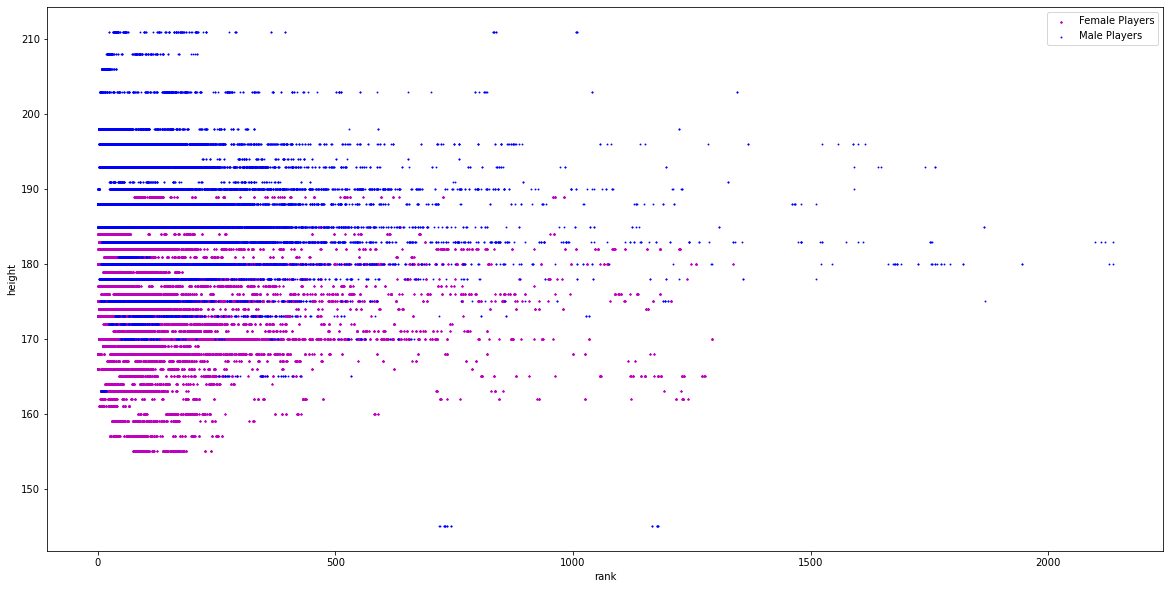

In [147]:
plt.figure(figsize=(20,10))
plt.scatter(df_player_data_nd[df_player_data_nd['gender'] == 'F']['player_rank'],
            df_player_data_nd[df_player_data_nd['gender'] == 'F']['player_ht'], color='m', marker='*', s=3, label='Female Players')
plt.scatter(df_player_data_nd[df_player_data_nd['gender'] == 'M']['player_rank'],
            df_player_data_nd[df_player_data_nd['gender'] == 'M']['player_ht'], color='b', marker='.', s=3, label='Male Players')


plt.xlabel('rank')
plt.ylabel('height')
plt.legend()
plt.show()

Let's see now how the attribute __'Winner_rank_points'__ is plotted, the results should be similar.

As we can see, the scale of the ranking is different, but the values are distributed in a similar way.

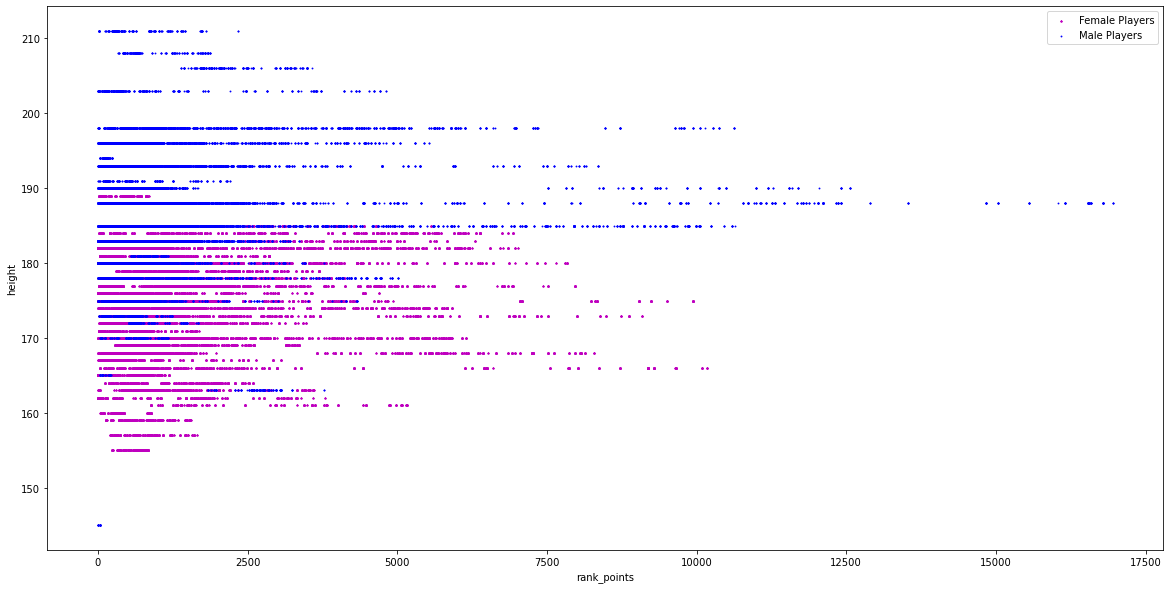

In [148]:
plt.figure(figsize=(20,10))
plt.scatter(df_player_data[df_player_data['gender'] == 'F']['player_rank_points'],
            df_player_data[df_player_data['gender'] == 'F']['player_ht'], color='m', marker='*', s=3, label='Female Players')
plt.scatter(df_player_data[df_player_data['gender'] == 'M']['player_rank_points'],
            df_player_data[df_player_data['gender'] == 'M']['player_ht'], color='b', marker='.', s=3, label='Male Players')


plt.xlabel('rank_points')
plt.ylabel('height')
plt.legend()
plt.show()

The Boxplot below shows which are the most common players' rank.

The average is about 350/400 points, but there are also many outliers, indeed there are players with a rank higher than 1500 points

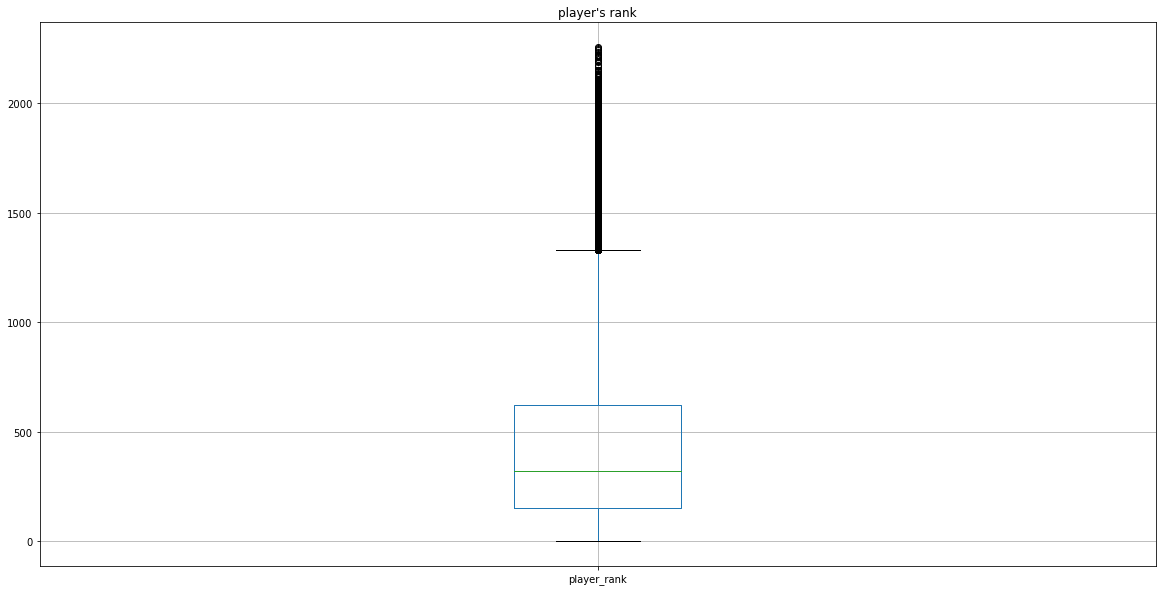

In [149]:
plt.figure(figsize=(20,10))
df_player_data_nd.boxplot(column='player_rank')
plt.title("player's rank")
plt.show()

This is the same Boxplot, but divided by players' gender. The average female player has a better rank than the average male player. However, the players with the highest score are almost all males.

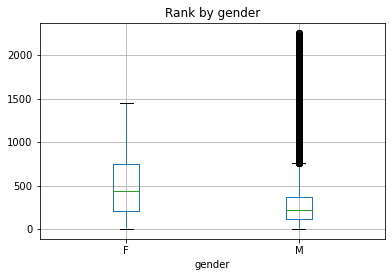

In [150]:
df_player_data_nd.boxplot(column='player_rank', by='gender')
plt.title("Rank by gender")
plt.suptitle('')
plt.show()

Here we can see which are the performances of the players that play with different hands. Unfortunately, the hand of some of the best players is unknown.

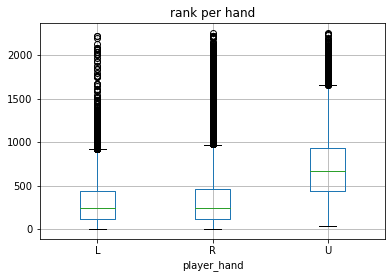

In [151]:
df_player_data_nd.boxplot(column='player_rank', by='player_hand')
plt.title("rank per hand")
plt.suptitle('')
plt.show()

We are creating a new dataframe containing all the information about the players, like their heigth, gender and favourite hand. It contains only one record for every player.

In [152]:
# Dataframe 'df_player_unique' has one and only one record for each player without any repetion
df_player_unique = df_player_data_nd.drop_duplicates(subset=['player_id'])
df_player_unique = df_player_unique[['player_id', 'player_name', 'player_ht', 'player_hand', 'gender']]

Players' favourite hand by gender. We have little information about the hand of the female players (the value unknown is the most common), however the situation is better for the male players. Overall it is possible to see that the right hand is most used than the left one.

<AxesSubplot:xlabel='gender'>

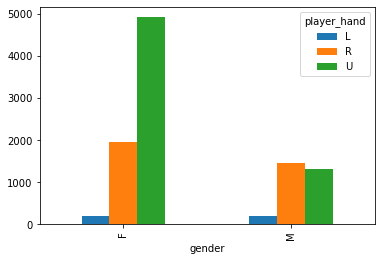

In [153]:
r = pd.crosstab(df_player_unique['gender'], df_player_unique['player_hand'])
r.plot(kind = 'bar')

Here was plotted the height by gender. As we could have imagined, the male players are typically taller than the female players.

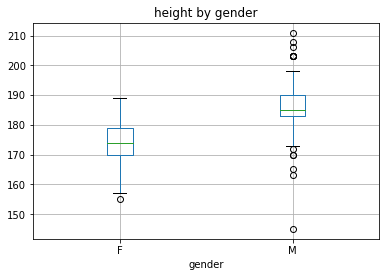

In [154]:
df_player_unique.boxplot(column='player_ht', by='gender')
plt.title("height by gender")
plt.suptitle('')
plt.show()

In the previous cells there were the data about the players, let's see now something about the tournament.

Below we created a new Dataframe containing all the information about the tournaments.

In [155]:
df_tourney = df_ten_match[['tourney_id', 'tourney_name', 'surface',
                           'draw_size', 'tourney_level', 'tourney_date',
                           'tourney_spectators', 'tourney_revenue']]
df_tourney = df_tourney.drop_duplicates(subset=['tourney_id'])

Firstly we plotted the revenue and the spectators of the tournament. The majority of them are local tournaments with a little revenue and few spectators. However, there are some of them that are more important and so they hosted more spectators and they had more revenues.

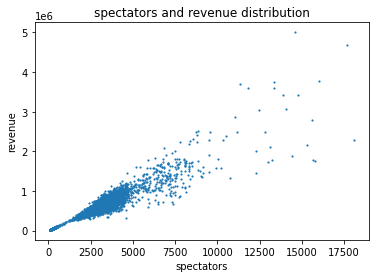

In [156]:
plt.scatter(df_tourney['tourney_spectators'], df_tourney['tourney_revenue'], s=1.3)

plt.xlabel('spectators')
plt.ylabel('revenue')
plt.title("spectators and revenue distribution")
plt.show()

The majority of the tournaments had few revenue, however few of them were probabily more important, because it jumps to the eye that they had a much higher revenue.

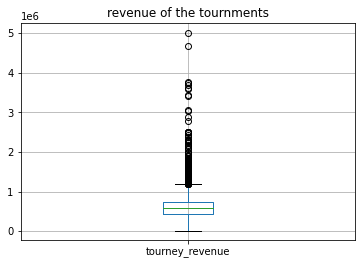

In [157]:
df_tourney.boxplot(column='tourney_revenue')
plt.title("revenue of the tournments")
plt.show()

Here the revenues were divided by the tournaments' level. Some level are probabily more importan than others, because in these tournaments the revenues were typically higher. 

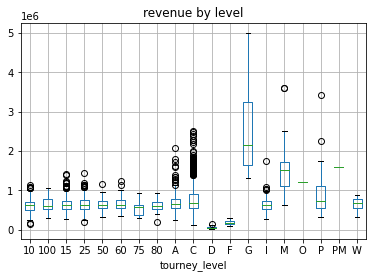

In [158]:
df_tourney.boxplot(column='tourney_revenue', by='tourney_level')
plt.title("revenue by level")
plt.suptitle('')
plt.show()

Here it is clearly visible that in average the tournaments had few spectators. However, few of them had many more of them, reaching also the number of 17.500

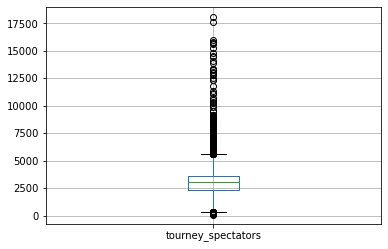

In [159]:
df_tourney.boxplot(column='tourney_spectators')
plt.show()

As we did for the revenues, we are plotting here the number of spectators for level. The results are similar, because there are some levels with many more spectators, like the level G (Grand Slam), and other with less spectators, like 10, 100, 15 and others.

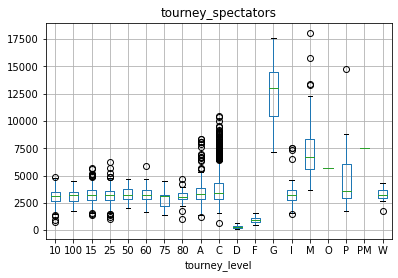

In [160]:
df_tourney.boxplot(column='tourney_spectators', by='tourney_level')
plt.suptitle('')
plt.show()

Other bar charts

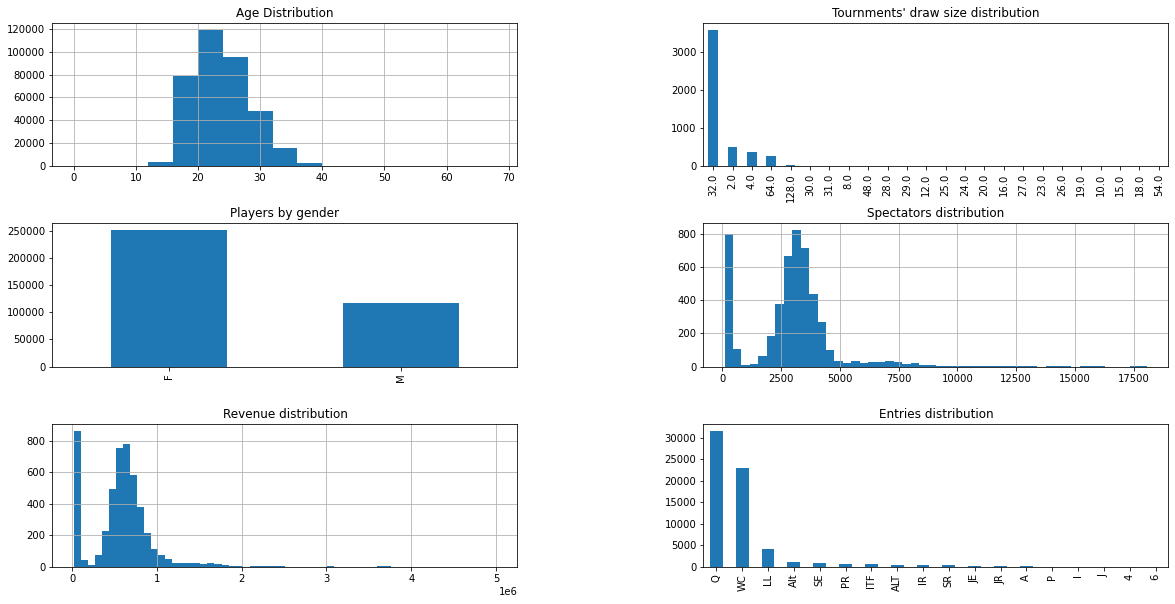

In [161]:
# set up a grid:
fig = plt.figure(figsize=(20, 10)) 
fig_dims = (3, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# plot age
plt.subplot2grid(fig_dims, (0, 0))
df_player_data['player_age'].hist(bins=np.arange(0,70,4))
plt.title("Age Distribution")

# plot tournment's draw size
plt.subplot2grid(fig_dims, (0, 1))
df_tourney['draw_size'].value_counts().plot(kind='bar')
plt.title("Tournments' draw size distribution")

# Total player by gender (here every players was counted as many times as they played a match, previously were counted the distinct players)
plt.subplot2grid(fig_dims, (1, 0))
df_player_data['gender'].value_counts().plot(kind='bar')
plt.title("Players by gender")

# Spectators distribution
plt.subplot2grid(fig_dims, (1, 1))
df_tourney['tourney_spectators'].hist(bins=50)
plt.title("Spectators distribution")

# Revenue distribution
plt.subplot2grid(fig_dims, (2, 0))
df_tourney['tourney_revenue'].hist(bins=60)
plt.title("Revenue distribution")

# Entries distribution
plt.subplot2grid(fig_dims, (2, 1))
df_player_data_nd['player_entry'].value_counts().plot(kind='bar')
plt.title("Entries distribution")

plt.show()

# Performance markers #

In this section we create from scratch new attributes that will be useful to understand more in depth the players' characteristics.

In [162]:
df_player_stats = pd.DataFrame()
df_player_stats['player_id'] = df_player_data['player_id']
df_player_stats = df_player_stats.drop_duplicates()
df_player_stats = df_player_stats.dropna()
df_player_stats = df_player_stats.reset_index(drop=True)

df_player_stats['ace'] = 0
df_player_stats['svpt'] = 0

We create a new dataframe with a record for each player and we both add new attributes and copy old statistics.

In [163]:
df_player_profile = pd.DataFrame()
df_player_profile['player_id'] = df_player_stats['player_id']

In [164]:
df_player_profile = pd.merge(df_player_profile, df_player_data
                           [['player_id','player_name', 'player_ht', 'player_hand']], on = 'player_id', how = 'inner')

In [165]:
df_player_profile.drop_duplicates(subset=['player_id'], inplace=True)
df_player_profile.reset_index(drop=True, inplace=True)

In [166]:
unique_players_ids = list(df_player_data['player_id'].dropna().unique())

We use two auxiliary dataframes (containing info about winners and losers) to compute different statistics.

In [167]:
df_loser_data  = df_loser_data[df_loser_data['tourney_date'].notna()]
df_winner_data = df_winner_data[df_winner_data['tourney_date'].notna()]

In [168]:
# we split the data for each year we have available
six_loser_data   = df_loser_data.loc[(df_loser_data['tourney_date'] >= 20160101) & ((df_loser_data['tourney_date'] < 20170101))]
seven_loser_data = df_loser_data.loc[(df_loser_data['tourney_date'] >= 20170101) & ((df_loser_data['tourney_date'] < 20180101))]
eight_loser_data = df_loser_data.loc[(df_loser_data['tourney_date'] >= 20180101) & ((df_loser_data['tourney_date'] < 20190101))]
nine_loser_data  = df_loser_data.loc[(df_loser_data['tourney_date'] >= 20190101) & ((df_loser_data['tourney_date'] < 20200101))]
ten_loser_data   = df_loser_data.loc[(df_loser_data['tourney_date'] >= 20200101) & ((df_loser_data['tourney_date'] < 20210101))]
tail_loser_data  = df_loser_data.loc[(df_loser_data['tourney_date'] >= 20210101) & ((df_loser_data['tourney_date'] < 20220101))]

num_losses       = []
six_num_losses   = []
seven_num_losses = []
eight_num_losses = []
nine_num_losses  = []
ten_num_losses   = []
tail_num_losses  = []

sconfitte        = []
six_sconfitte    = []
seven_sconfitte  = []
eight_sconfitte  = []
nine_sconfitte   = []
ten_sconfitte    = []
tail_sconfitte   = []

for i in range(len(unique_players_ids)):
    
    # we compute the number of losses (filtering by player id) and we add it to the appropriate year...
    num_losses.append(np.where(df_loser_data['player_id']==unique_players_ids[i])[0])
    sconfitte.append(len(num_losses[i]))
    
    # ... 
    six_num_losses.append(np.where(six_loser_data['player_id']==unique_players_ids[i])[0])
    six_sconfitte.append(len(six_num_losses[i]))
    
    # ...
    seven_num_losses.append(np.where(seven_loser_data['player_id']==unique_players_ids[i])[0])
    seven_sconfitte.append(len(seven_num_losses[i]))
    
    # ... 
    eight_num_losses.append(np.where(eight_loser_data['player_id']==unique_players_ids[i])[0])
    eight_sconfitte.append(len(eight_num_losses[i]))
    
    # ...
    nine_num_losses.append(np.where(nine_loser_data['player_id']==unique_players_ids[i])[0])
    nine_sconfitte.append(len(nine_num_losses[i]))
    
    # ...
    ten_num_losses.append(np.where(ten_loser_data['player_id']==unique_players_ids[i])[0])
    ten_sconfitte.append(len(ten_num_losses[i]))
    
    # ... for each year.
    tail_num_losses.append(np.where(tail_loser_data['player_id']==unique_players_ids[i])[0])
    tail_sconfitte.append(len(tail_num_losses[i]))
    


In [169]:
# we repeat the same computation we did in the previous cell for the winner data
six_winner_data   = df_winner_data.loc[(df_winner_data['tourney_date'] >= 20160101) & ((df_winner_data['tourney_date'] < 20170101))]
seven_winner_data = df_winner_data.loc[(df_winner_data['tourney_date'] >= 20170101) & ((df_winner_data['tourney_date'] < 20180101))]
eight_winner_data = df_winner_data.loc[(df_winner_data['tourney_date'] >= 20180101) & ((df_winner_data['tourney_date'] < 20190101))]
nine_winner_data  = df_winner_data.loc[(df_winner_data['tourney_date'] >= 20190101) & ((df_winner_data['tourney_date'] < 20200101))]
ten_winner_data   = df_winner_data.loc[(df_winner_data['tourney_date'] >= 20200101) & ((df_winner_data['tourney_date'] < 20210101))]
tail_winner_data  = df_winner_data.loc[(df_winner_data['tourney_date'] >= 20210101) & ((df_winner_data['tourney_date'] < 20220101))]

num_wins          = []
six_num_wins      = []
seven_num_wins    = []
eight_num_wins    = []
nine_num_wins     = []
ten_num_wins      = []
tail_num_wins     = []

vittorie          = []
six_vittorie      = []
seven_vittorie    = []
eight_vittorie    = []
nine_vittorie     = []
ten_vittorie      = []
tail_vittorie     = []

for i in range(len(unique_players_ids)):
    
    num_wins.append(np.where(df_winner_data['player_id']==unique_players_ids[i])[0])
    vittorie.append(len(num_wins[i]))
    
    six_num_wins.append(np.where(six_winner_data['player_id']==unique_players_ids[i])[0])
    six_vittorie.append(len(six_num_wins[i]))
    
    seven_num_wins.append(np.where(seven_winner_data['player_id']==unique_players_ids[i])[0])
    seven_vittorie.append(len(seven_num_wins[i]))
    
    eight_num_wins.append(np.where(eight_winner_data['player_id']==unique_players_ids[i])[0])
    eight_vittorie.append(len(eight_num_wins[i]))
    
    nine_num_wins.append(np.where(nine_winner_data['player_id']==unique_players_ids[i])[0])
    nine_vittorie.append(len(nine_num_wins[i]))
    
    ten_num_wins.append(np.where(ten_winner_data['player_id']==unique_players_ids[i])[0])
    ten_vittorie.append(len(ten_num_wins[i]))
    
    tail_num_wins.append(np.where(tail_winner_data['player_id']==unique_players_ids[i])[0])
    tail_vittorie.append(len(tail_num_wins[i]))

Now we can start adding the new computed attributes to the players profile dataframe

In [170]:
partite_totali = [x + y for x, y in zip(vittorie, sconfitte)]

For each year, we'll record the number of wins, the number of losses, the total games played and the relative winrate

In [171]:
df_player_profile['total_wins']   = vittorie
df_player_profile['total_losses'] = sconfitte
df_player_profile['total_games']  = partite_totali

In [172]:
df_player_profile['16/17_wins'] = six_vittorie
df_player_profile['17/18_wins'] = seven_vittorie
df_player_profile['18/19_wins'] = eight_vittorie
df_player_profile['19/20_wins'] = nine_vittorie
df_player_profile['20/21_wins'] = ten_vittorie
df_player_profile['21/22_wins'] = tail_vittorie

df_player_profile['16/17_losses'] = six_sconfitte
df_player_profile['17/18_losses'] = seven_sconfitte
df_player_profile['18/19_losses'] = eight_sconfitte
df_player_profile['19/20_losses'] = nine_sconfitte
df_player_profile['20/21_losses'] = ten_sconfitte
df_player_profile['21/22_losses'] = tail_sconfitte

df_player_profile['16/17_games'] = [x + y for x, y in zip(six_vittorie, six_sconfitte)]
df_player_profile['17/18_games'] = [x + y for x, y in zip(seven_vittorie, seven_sconfitte)]
df_player_profile['18/19_games'] = [x + y for x, y in zip(eight_vittorie, eight_sconfitte)]
df_player_profile['19/20_games'] = [x + y for x, y in zip(nine_vittorie, nine_sconfitte)]
df_player_profile['20/21_games'] = [x + y for x, y in zip(ten_vittorie, ten_sconfitte)]
df_player_profile['21/22_games'] = [x + y for x, y in zip(tail_vittorie, tail_sconfitte)]

df_player_profile['total_winrate'] = [x/(x+y) if x+y!=0 else 0 for x, y in zip(vittorie, sconfitte)]
df_player_profile['16/17_winrate'] = [x/(x+y) if x+y!=0 else 0 for x, y in zip(six_vittorie, six_sconfitte)]
df_player_profile['17/18_winrate'] = [x/(x+y) if x+y!=0 else 0 for x, y in zip(seven_vittorie, seven_sconfitte)]
df_player_profile['18/19_winrate'] = [x/(x+y) if x+y!=0 else 0 for x, y in zip(eight_vittorie, eight_sconfitte)]
df_player_profile['19/20_winrate'] = [x/(x+y) if x+y!=0 else 0 for x, y in zip(nine_vittorie, nine_sconfitte)]
df_player_profile['20/21_winrate'] = [x/(x+y) if x+y!=0 else 0 for x, y in zip(ten_vittorie, ten_sconfitte)]
df_player_profile['21/22_winrate'] = [x/(x+y) if x+y!=0 else 0 for x, y in zip(tail_vittorie, tail_sconfitte)]

Here we created other variables about the perfomances of the players.

In [173]:
df_player_profile['ace'] = 0  #Total number of aces
df_player_profile['svpt'] = 0 #Total number of svpt
df_player_profile['firstwon'] = 0  #Total points in the first service
df_player_profile['secondwon'] = 0 #Total points in the second service
df_player_profile['df'] = 0  #Total number of doubles faults
df_player_profile['bp_s'] = 0  #Total number of breakpoints saved
df_player_profile['bp_f'] = 0  #Total number of breakpoints faced
df_player_profile['ace_per_svpt'] = np.nan  #Ratio between total number of aces and total number of svpt
df_player_profile['first_serv_rt'] = np.nan #percentage of points scored in the first service in the total of points
df_player_profile['avg_df'] = np.nan  #average number of doubles faults per match
df_player_profile['avg_ace'] = np.nan #average number of aces per match
df_player_profile['fvrt_level'] = np.nan #level where the player played most times
df_player_profile['mc_entry'] = np.nan   #The most typical entry of the player
df_player_profile['last_date'] = np.nan #Last time that a player played a tournament
df_player_profile['01/09/2021_age'] = np.nan #Age of the player on 1st Semptember 2021
df_player_profile['perc_bs'] = 0 #percentage of breakpoints saved in the total of breakpoints

df_player_profile['avg_minutes'] = np.nan #average length of the matches played
df_player_profile['highest_scr'] = 0 #highest score ever reached by the player
df_player_profile['avg_scr'] = 0     #average rank points per player. #ADDED FOR TASK 3
df_player_profile['SvGms'] = np.nan  #average number of serve games #ADDED FOR TASK 3

Below we computed these new variables

In [174]:
print(len(df_player_profile))
df_player_data = df_player_data.sort_values(by=['player_id'])

i = 0
while i < len(df_player_profile):
    p_id = df_player_profile['player_id'].iloc[i]
    id_player_match = np.where(df_player_data['player_id'] == p_id)[0]
    
    ace = 0
    svpt = 0
    stwon = 0
    ndwon = 0
    p_df = 0
    number_df = 0
    ace_2 = 0
    number_ace = 0
    
    maximum_day = 0
    maximum_month = 0
    maximum_year = 0
    bp_s = 0
    bp_f = 0
    age = 0
    date = 0
    
    minutes = 0
    occ_minutes = 0
    
    rank_points = 0
    occ_rank_points = 0
    
    highest_score = 0
    
    serve_games = 0
    occ_serve_games = 0
    
    
    d_level = {
        '15': 0,
        'C': 0,
        '25': 0,
        'A': 0,
        '10': 0,
        'G': 0,
        'I': 0,
        '60': 0,
        'P': 0,
        'M': 0,
        '100': 0,
        'D': 0,
        '80': 0,
        '50': 0,
        'PM': 0,
        'W': 0,
        'F': 0,
        '75': 0,
        'O': 0
    }
    
    entries = {
        'Q': 0,
        'WC': 0,
        'LL': 0,
        'SE': 0,
        'Alt': 0,
        'PR': 0,
        'ITF': 0,
        'ALT': 0,
        'IR': 0,
        'SR': 0,
        'JR': 0,
        'JE': 0,
        'A': 0,
        'P': 0,
        'I': 0,
        'J': 0,
        '6': 0,
        '4': 0,
        '3': 0
    }
    for j in id_player_match:
        if not math.isnan(df_player_data['SvGms'].iloc[j]): #Computing average number of serve games
            serve_games = serve_games + df_player_data['SvGms'].iloc[j]
            occ_serve_games = occ_serve_games + 1
        if not math.isnan(df_player_data['player_rank_points'].iloc[j]): #Updating highest score of the player and updating total rank point (to compute the average)
            rank_points = rank_points + df_player_data['player_rank_points'].iloc[j]
            occ_rank_points = occ_rank_points + 1
            if df_player_data['player_rank_points'].iloc[j] > highest_score:
                highest_score = df_player_data['player_rank_points'].iloc[j]
        if not math.isnan(df_player_data['minutes'].iloc[j]): #Updtaing total number of minutes that a player played (to compute the average)
            minutes = minutes + df_player_data['minutes'].iloc[j]
            occ_minutes = occ_minutes + 1
        if not math.isnan(df_player_data['ace'].iloc[j]) and not math.isnan(df_player_data['svpt'].iloc[j]): #Updtating total number of aces and svpt
            ace = ace + df_player_data['ace'].iloc[j]
            svpt = svpt + df_player_data['svpt'].iloc[j]            
        if not math.isnan(df_player_data['1stWon'].iloc[j]) and not math.isnan(df_player_data['2ndWon'].iloc[j]): #Updating the totl number of first and second serve points
            stwon = stwon + df_player_data['1stWon'].iloc[j]
            ndwon = ndwon + df_player_data['2ndWon'].iloc[j]
        if not math.isnan(df_player_data['df'].iloc[j]): #Updating total number of doubles faults
            p_df = p_df + df_player_data['df'].iloc[j]
            number_df = number_df + 1
        if not math.isnan(df_player_data['ace'].iloc[j]): #Updating total number of aces
            ace_2 = ace_2 + df_player_data['ace'].iloc[j]
            number_ace = number_ace + 1
        if df_player_data['tourney_level'].iloc[j] == df_player_data['tourney_level'].iloc[j]: #Saving the level of the match
            lvl = df_player_data['tourney_level'].iloc[j]
            d_level[lvl] = d_level[lvl] + 1
        if df_player_data['player_entry'].iloc[j] == df_player_data['player_entry'].iloc[j]: #Saving the entry of the player
            ent = df_player_data['player_entry'].iloc[j]
            entries[ent] = entries[ent] + 1
        if not math.isnan(df_player_data['bpSaved'].iloc[j]) and not math.isnan(df_player_data['bpFaced'].iloc[j]): #Updating total number of breakpoints saved and faced
            bp_s = bp_s + df_player_data['bpSaved'].iloc[j]
            bp_f = bp_f + df_player_data['bpFaced'].iloc[j]
        if not math.isnan(df_player_data['tourney_date'].iloc[j]): #Updating last date that a player played
            match_date = df_player_data['tourney_date'].iloc[j]
            match_year = int(str(match_date)[0:4])
            match_month = int(str(match_date)[4:6])
            match_day = int(str(match_date)[6:8])
            if (maximum_year < match_year) or (maximum_year == match_year and maximum_month < match_month ) or (maximum_year == match_year and maximum_month == match_month  and maximum_day < match_day):
                maximum_year = match_year
                maximum_month = match_month
                maximum_day = match_day
                age = df_player_data['player_age'].iloc[j]
                
    if (minutes > 0):
        df_player_profile.loc[[i],['avg_minutes']] = minutes / occ_minutes
    if (rank_points > 0):
        df_player_profile.loc[[i],['avg_scr']] = rank_points / occ_rank_points
    if (highest_score > 0):
        df_player_profile.loc[[i],['highest_scr']] = highest_score
        
    if (maximum_month / 10 < 1):
        maximum_month = '0' + str(maximum_month)
    if (maximum_day / 10 < 1):
        maximum_day = '0' + str(maximum_day)
    final_date = int(str(maximum_year) + str(maximum_month) + str(maximum_day))
    if final_date > 0:
        df_player_profile.loc[[i],['last_date']] = final_date
    
    g_year = 2021 - float(maximum_year)
    g_month = (9 - float(maximum_month))/12
    g_day = (1 - float(maximum_day))/(12*30)
    
    g_age = g_year + g_month + g_day
    if age > 0:
        age = age + g_age
        df_player_profile.loc[[i],['01/09/2021_age']] = age
    
    df_player_profile.loc[[i],['bp_s']] = bp_s 
    df_player_profile.loc[[i],['bp_f']] = bp_f
    if (bp_s + bp_f > 0):
        df_player_profile.loc[[i],['perc_bs']] = bp_s / (bp_s + bp_f)
    
    maximum_l = 0
    level = np.nan
    for h in d_level:
        if d_level[h] > maximum_l:
            maximum_l = d_level[h]
            level = h
    df_player_profile.loc[[i],['fvrt_level']] = level
    
    maximum_ent = 0
    entry = np.nan
    for h in entries:
        if entries[h] > maximum_ent:
            maximum_ent = entries[h]
            entry = h
    df_player_profile.loc[[i],['mc_entry']] = entry
            
    df_player_profile.loc[[i],['ace']] = ace
    df_player_profile.loc[[i],['svpt']] = svpt
    if svpt != 0:
        df_player_profile.loc[[i],['ace_per_svpt']] = ace / svpt
    else:
        df_player_profile.loc[[i],['ace_per_svpt']] = 0
        
    df_player_profile.loc[[i],['firstwon']] = stwon
    df_player_profile.loc[[i],['secondwon']] = ndwon
    if stwon + ndwon > 0:
        df_player_profile.loc[[i],['first_serv_rt']] = stwon / (stwon + ndwon)
    else:
        df_player_profile.loc[[i],['first_serv_rt']] = 0
        
    df_player_profile.loc[[i],['df']] = p_df
    if number_df != 0:
        df_player_profile.loc[[i],['avg_df']] = p_df / number_df
    else:
        df_player_profile.loc[[i],['avg_df']] = 0
        
    if number_ace > 0:
        df_player_profile.loc[[i],['avg_ace']] = ace_2 / number_ace
    else:
        df_player_profile.loc[[i],['avg_ace']] = 0
        
    if occ_serve_games > 0:
        df_player_profile.loc[[i],['SvGms']] = serve_games / occ_serve_games
    
    
    i = i + 1

10074


The new dataset created

In [175]:
df_player_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10074 entries, 0 to 10073
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player_id       10074 non-null  float64
 1   player_name     10074 non-null  object 
 2   player_ht       541 non-null    float64
 3   player_hand     10074 non-null  object 
 4   total_wins      10074 non-null  int64  
 5   total_losses    10074 non-null  int64  
 6   total_games     10074 non-null  int64  
 7   16/17_wins      10074 non-null  int64  
 8   17/18_wins      10074 non-null  int64  
 9   18/19_wins      10074 non-null  int64  
 10  19/20_wins      10074 non-null  int64  
 11  20/21_wins      10074 non-null  int64  
 12  21/22_wins      10074 non-null  int64  
 13  16/17_losses    10074 non-null  int64  
 14  17/18_losses    10074 non-null  int64  
 15  18/19_losses    10074 non-null  int64  
 16  19/20_losses    10074 non-null  int64  
 17  20/21_losses    10074 non-null 

# Part 2 #

# Preparing data #

## Studying remained null values ##

We would like to eliminate the remaining missing values in this new dataframe.

In [176]:
print(len(df_player_profile))
df_player_profile.isnull().sum()

10074


player_id            0
player_name          0
player_ht         9533
player_hand          0
total_wins           0
total_losses         0
total_games          0
16/17_wins           0
17/18_wins           0
18/19_wins           0
19/20_wins           0
20/21_wins           0
21/22_wins           0
16/17_losses         0
17/18_losses         0
18/19_losses         0
19/20_losses         0
20/21_losses         0
21/22_losses         0
16/17_games          0
17/18_games          0
18/19_games          0
19/20_games          0
20/21_games          0
21/22_games          0
total_winrate        0
16/17_winrate        0
17/18_winrate        0
18/19_winrate        0
19/20_winrate        0
20/21_winrate        0
21/22_winrate        0
ace                  0
svpt                 0
firstwon             0
secondwon            0
df                   0
bp_s                 0
bp_f                 0
ace_per_svpt         0
first_serv_rt        0
avg_df               0
avg_ace              0
fvrt_level 

In [177]:
age_median = df_player_profile['01/09/2021_age'].median()  #computing the median for the age
minutes_median = df_player_profile['avg_minutes'].median() #computing the median for the average match length

values = {'01/09/2021_age': age_median, 'avg_minutes': minutes_median}
df_player_profile = df_player_profile.fillna(value=values)

Most of them were corrected

In [178]:
df_player_profile.isnull().sum()

player_id            0
player_name          0
player_ht         9533
player_hand          0
total_wins           0
total_losses         0
total_games          0
16/17_wins           0
17/18_wins           0
18/19_wins           0
19/20_wins           0
20/21_wins           0
21/22_wins           0
16/17_losses         0
17/18_losses         0
18/19_losses         0
19/20_losses         0
20/21_losses         0
21/22_losses         0
16/17_games          0
17/18_games          0
18/19_games          0
19/20_games          0
20/21_games          0
21/22_games          0
total_winrate        0
16/17_winrate        0
17/18_winrate        0
18/19_winrate        0
19/20_winrate        0
20/21_winrate        0
21/22_winrate        0
ace                  0
svpt                 0
firstwon             0
secondwon            0
df                   0
bp_s                 0
bp_f                 0
ace_per_svpt         0
first_serv_rt        0
avg_df               0
avg_ace              0
fvrt_level 

## Studying correlation ##

We wants to study the correlation among the variables of __"df_player_profile"__. Indeed is important to discard all the varibles highly correlated before applying the cluster algorithms. Below there is the table of the correlations.

In [179]:
pd.set_option("display.max_rows", None, "display.max_columns", None) #display all rows/cols
df_player_profile.corr()

,player_id,player_ht,total_wins,total_losses,total_games,16/17_wins,17/18_wins,18/19_wins,19/20_wins,20/21_wins,21/22_wins,16/17_losses,17/18_losses,18/19_losses,19/20_losses,20/21_losses,21/22_losses,16/17_games,17/18_games,18/19_games,19/20_games,20/21_games,21/22_games,total_winrate,16/17_winrate,17/18_winrate,18/19_winrate,19/20_winrate,20/21_winrate,21/22_winrate,ace,svpt,firstwon,secondwon,df,bp_s,bp_f,ace_per_svpt,first_serv_rt,avg_df,avg_ace,last_date,01/09/2021_age,perc_bs,avg_minutes,highest_scr,avg_scr,SvGms
player_id,1.000000,-0.574639,-0.183455,-0.208466,-0.197388,-0.234423,-0.207889,-0.206448,-0.091052,-0.080744,-0.036133,-0.279468,-0.243827,-0.240953,-0.094815,-0.097201,-0.040993,-0.261242,-0.229899,-0.227736,-0.095503,-0.091763,-0.039836,-0.114776,-0.332932,-0.285443,-0.192566,0.008411,-0.011644,0.047676,-0.383164,-0.404939,-0.407551,-0.412654,-0.373641,-0.389697,-0.381450,-0.635688,-0.659521,-0.482353,-0.629804,0.235385,-0.552398,-0.682255,-0.020092,-0.163183,-0.175116,-0.232675
player_ht,-0.574639,1.000000,-0.006726,0.007480,-0.000853,-0.029769,0.013740,0.033163,-0.043003,0.011107,-0.010804,-0.013528,0.020375,0.016533,0.002926,0.023336,-0.009358,-0.024684,0.017284,0.027495,-0.025899,0.016820,-0.010783,-0.044740,-0.074915,-0.024809,-0.023150,-0.057635,-0.049051,-0.041504,0.491791,0.161296,0.219530,0.209118,0.117598,0.032565,-0.026741,0.631588,0.135407,-0.000076,0.641511,0.005725,0.116087,0.294165,0.083133,-0.005397,-0.020166,0.358022
total_wins,-0.183455,-0.006726,1.000000,0.942096,0.988551,0.813584,0.880473,0.905025,0.878215,0.754132,0.704092,0.751101,0.841106,0.874034,0.820679,0.766884,0.724993,0.809135,0.887301,0.915640,0.878275,0.792931,0.742829,0.547440,0.644815,0.696372,0.704698,0.641152,0.614888,0.582979,0.618809,0.755803,0.746975,0.739825,0.738085,0.764070,0.768032,0.309474,0.351295,0.228083,0.329528,0.387924,0.195947,0.379373,0.269974,0.589246,0.567159,0.253553
total_losses,-0.208466,0.007480,0.942096,1.000000,0.981909,0.779417,0.837622,0.860259,0.841529,0.675762,0.625653,0.810388,0.895268,0.929239,0.887716,0.786835,0.738245,0.815637,0.887001,0.915021,0.887882,0.755859,0.702649,0.514368,0.637340,0.685249,0.696790,0.627097,0.583077,0.537956,0.600077,0.746101,0.732855,0.730794,0.731952,0.760226,0.766881,0.307138,0.343925,0.221536,0.325586,0.414071,0.218775,0.372297,0.259883,0.453237,0.439604,0.252534
total_games,-0.197388,-0.000853,0.988551,0.981909,1.000000,0.810092,0.874051,0.898100,0.874534,0.729883,0.679082,0.788747,0.877760,0.911639,0.862828,0.787061,0.741544,0.823878,0.900125,0.928734,0.895425,0.787831,0.735599,0.540554,0.650869,0.701537,0.711432,0.644191,0.609555,0.571235,0.619418,0.762476,0.751531,0.746566,0.746105,0.773499,0.778731,0.312943,0.353109,0.228468,0.332567,0.405354,0.209080,0.381730,0.269376,0.536654,0.518049,0.256728
16/17_wins,-0.234423,-0.029769,0.813584,0.779417,0.810092,1.000000,0.798498,0.705548,0.572023,0.436396,0.365513,0.887735,0.824989,0.700824,0.547515,0.458254,0.407432,0.978725,0.832736,0.722644,0.577988,0.465434,0.399691,0.440788,0.734637,0.611704,0.528666,0.397856,0.355758,0.302080,0.534256,0.656124,0.646370,0.643188,0.637685,0.664873,0.670228,0.302510,0.330297,0.214056,0.319614,0.195909,0.336551,0.356353,0.229301,0.536122,0.547553,0.226685
17/18_wins,-0.207889,0.013740,0.880473,0.837622,0.874051,0.798498,1.000000,0.799496,0.667602,0.511737,0.456067,0.761005,0.891204,0.815205,0.640975,0.544206,0.494224,0.804753,0.978856,0.828426,0.675466,0.548899,0.492306,0.445892,0.633675,0.740214,0.595162,0.471943,0.419389,0.379328,0.573258,0.690557,0.682584,0.675448,0.675214,0.697255,0.701762,0.305551,0.343000,0.225811,0.323301,0.269010,0.270215,0.367476,0.230956,0.539596,0.532270,0.223535
18/19_wins,-0.206448,0.033163,0.905025,0.860259,0.898100,0.705548,0.799496,1.000000,0.761487,0.604741,0.531367,0.658180,0.768229,0.893789,0.757868,0.647963,0.587354,0.704728,0.807716,0.979069,0.782681,0.650864,0.578810,0.455817,0.576681,0.646162,0.736809,0.544045,0.494525,0.449582,0.609803,0.735257

Below we highlighted the pairs with the highest correlations.

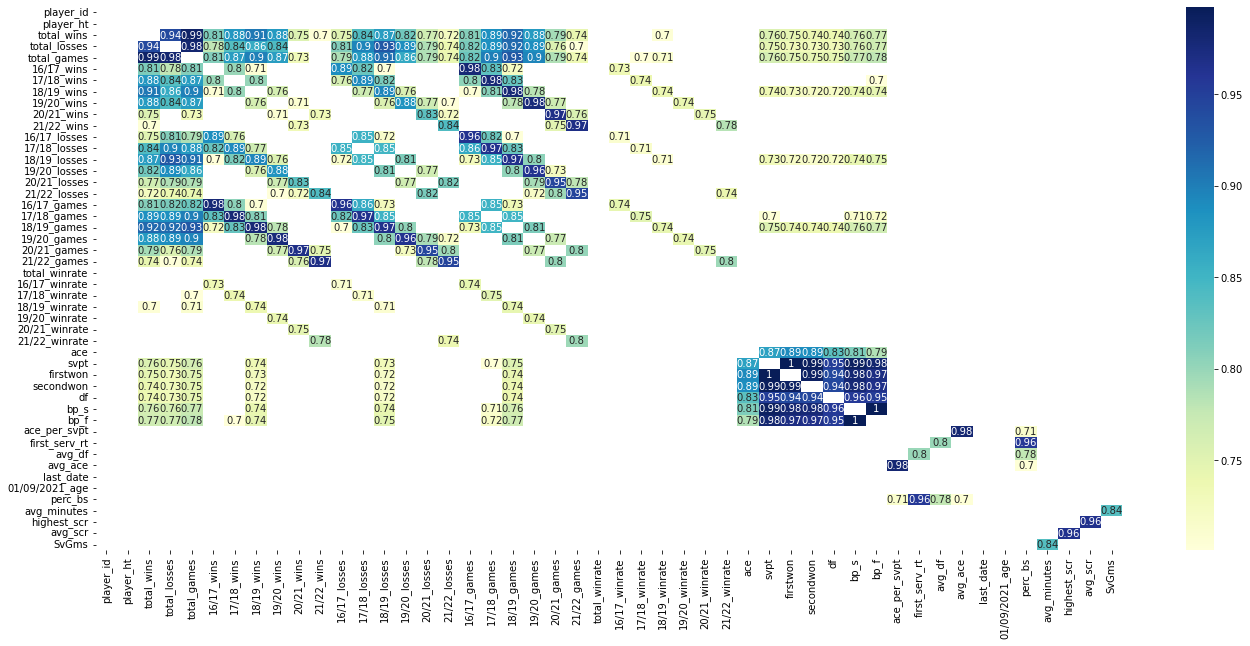

In [180]:
corr = df_player_profile.corr()
kot = corr[((corr>=.7) | (corr<=-0.7)) & (corr!=1.0)]
plt.figure(figsize=(23,10))
sns.heatmap(kot, annot=True, cmap="YlGnBu")
plt.show()

Here a list with the highest correlations in the dataset.


In [181]:
abs_corr = df_player_profile.corr().abs()


#eliminating the pairs belonging to the lowest triangle and to the diagonal
cols = abs_corr.columns
for i in range(0, abs_corr.shape[1]):
    for j in range(0, i+1):
        abs_corr.loc[cols[i],cols[j]] = 0
        
au_corr = abs_corr.unstack()
au_corr = au_corr[au_corr>=0.75]
au_corr = au_corr.sort_values(ascending=False)

print(au_corr)

bp_f           bp_s             0.997884
firstwon       svpt             0.997317
secondwon      svpt             0.993866
bp_s           svpt             0.991386
secondwon      firstwon         0.990798
total_games    total_wins       0.988551
bp_f           svpt             0.983668
total_games    total_losses     0.981909
bp_s           firstwon         0.981417
avg_ace        ace_per_svpt     0.981088
18/19_games    18/19_wins       0.979069
17/18_games    17/18_wins       0.978856
16/17_games    16/17_wins       0.978725
bp_s           secondwon        0.978312
19/20_games    19/20_wins       0.976863
bp_f           firstwon         0.970501
21/22_games    21/22_wins       0.969492
20/21_games    20/21_wins       0.967823
bp_f           secondwon        0.966845
18/19_games    18/19_losses     0.966361
17/18_games    17/18_losses     0.965145
avg_scr        highest_scr      0.964661
19/20_games    19/20_losses     0.963354
16/17_games    16/17_losses     0.963303
perc_bs        f

Now we can delete some attributes for the clustering.

In [182]:
df_player_profile_corr = df_player_profile[['player_id','player_ht','total_games','total_winrate','svpt','ace_per_svpt','first_serv_rt','last_date','01/09/2021_age', 'avg_minutes', 'highest_scr']]

In [183]:
df_player_profile_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10074 entries, 0 to 10073
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player_id       10074 non-null  float64
 1   player_ht       541 non-null    float64
 2   total_games     10074 non-null  int64  
 3   total_winrate   10074 non-null  float64
 4   svpt            10074 non-null  int64  
 5   ace_per_svpt    10074 non-null  float64
 6   first_serv_rt   10074 non-null  float64
 7   last_date       10074 non-null  float64
 8   01/09/2021_age  10074 non-null  float64
 9   avg_minutes     10074 non-null  float64
 10  highest_scr     10074 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 865.9 KB


Now the variables are less correlated among them.

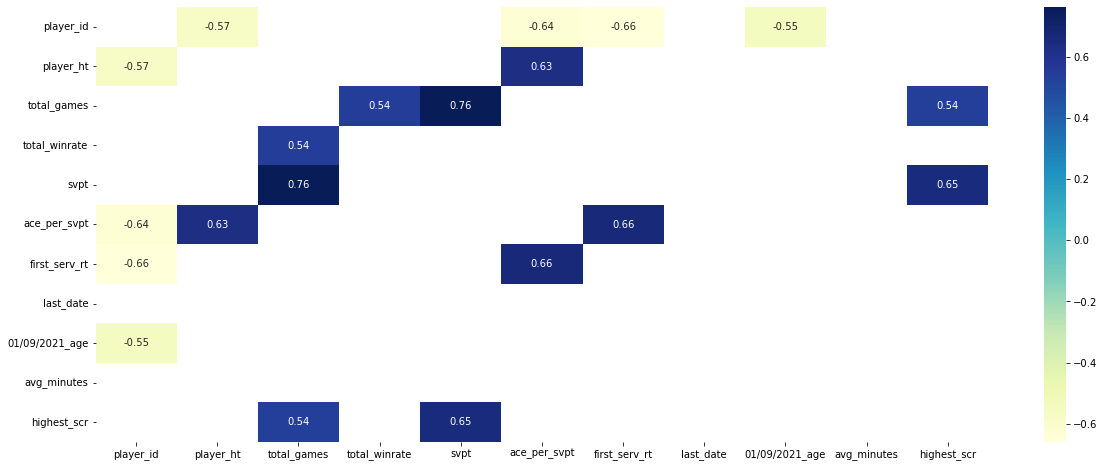

In [184]:
corr = df_player_profile_corr.corr()
kot = corr[((corr>=.5) | (corr<=-0.5)) & (corr!=1.0)]
plt.figure(figsize=(20,8))
sns.heatmap(kot, annot=True, cmap="YlGnBu")
plt.savefig('aft_corr')
plt.show()

In [185]:
df_player_profile.to_csv('tennis_profile.csv')
df_player_profile_corr.to_csv('tennis_profile_corr.csv')

## Studying data distribution ##

We are going to study the distribution of the new variables in the new dataframes created.

Below is plotted the ratio of matches won by each player, The majority of the players have a winrate under 0.5.

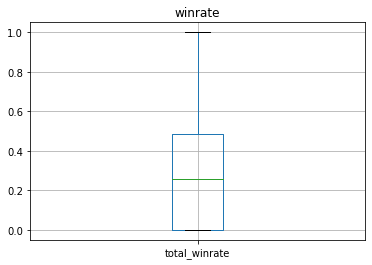

In [186]:
df_player_profile.boxplot(column='total_winrate')
plt.title("winrate")
plt.show()

The next graph shows how many matches a player won and lost. As we can see, the majority of these players lost and won about the same number of matches.

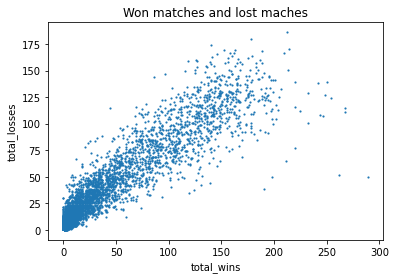

In [187]:
plt.scatter(df_player_profile['total_wins'], df_player_profile['total_losses'], s=1.3)

plt.xlabel('total_wins')
plt.ylabel('total_losses')
plt.title("Won matches and lost maches")
plt.show()

Looking at the graph below, we can understand who are the players with the best service. Only few of them have a percentage greater than 0.05% of Ace per number of serve points.

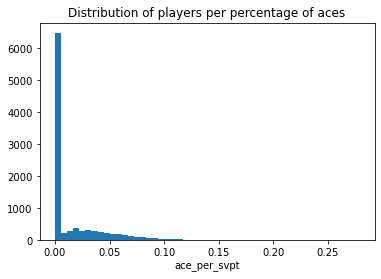

In [188]:
plt.hist(df_player_profile['ace_per_svpt'], bins=50)
plt.title("Distribution of players per percentage of aces")
plt.xlabel("ace_per_svpt")
plt.show()

The function of the distribution of the age of the players is similar to a Gaussian, however it is a little moved to the right. A lot of them are about 27, because we corrected the missing values using the median.

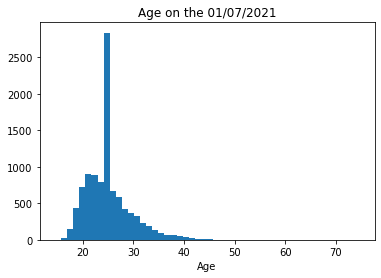

In [189]:
plt.hist(df_player_profile['01/09/2021_age'], bins=50)
plt.title("Age on the 01/07/2021")
plt.xlabel("Age")
plt.show()

This graph shows the percentage of breakpoints saved on the total. Probabily a lot of players have a value of 0 due to the presence of missing values on the attributes __"W/L_bdSaved"__ and __"W/L_bdFaced"__.

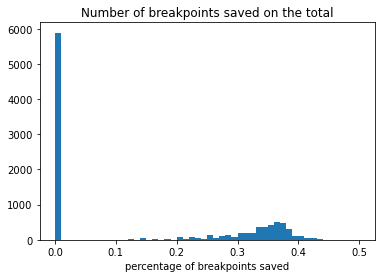

In [190]:
plt.hist(df_player_profile['perc_bs'], bins=50)
plt.title("Number of breakpoints saved on the total")
plt.xlabel("percentage of breakpoints saved")
plt.show()

Below it is possible to see that the majority of the players score more points in the first service. Again we have a lot of records with a value equal to 0 for the presence of missing values on the original dataframe.

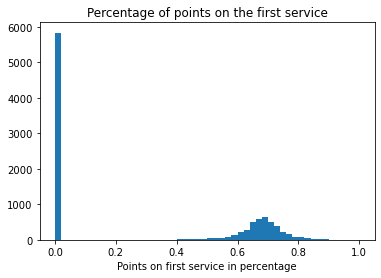

In [191]:
plt.hist(df_player_profile['first_serv_rt'], bins=50)
plt.title("Percentage of points on the first service")
plt.xlabel("Points on first service in percentage")
plt.show()

In [192]:
df_player_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10074 entries, 0 to 10073
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player_id       10074 non-null  float64
 1   player_name     10074 non-null  object 
 2   player_ht       541 non-null    float64
 3   player_hand     10074 non-null  object 
 4   total_wins      10074 non-null  int64  
 5   total_losses    10074 non-null  int64  
 6   total_games     10074 non-null  int64  
 7   16/17_wins      10074 non-null  int64  
 8   17/18_wins      10074 non-null  int64  
 9   18/19_wins      10074 non-null  int64  
 10  19/20_wins      10074 non-null  int64  
 11  20/21_wins      10074 non-null  int64  
 12  21/22_wins      10074 non-null  int64  
 13  16/17_losses    10074 non-null  int64  
 14  17/18_losses    10074 non-null  int64  
 15  18/19_losses    10074 non-null  int64  
 16  19/20_losses    10074 non-null  int64  
 17  20/21_losses    10074 non-null 